# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](../../Desktop/Module%2017%20Submission/Ω%20Old%20Stuff/module_17_starter%202/CRISP-DM-BANK.pdf) for more information on the data and features.



### Import & Helper Functions

In [27]:
import os
import sys
import shutil
import warnings
import logging
from datetime import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tabulate import tabulate
from typing import Optional, Tuple, Dict, Any, List, Union

from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # Example, not used by default
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from scipy.cluster.hierarchy import linkage, leaves_list

from imblearn.over_sampling import SMOTE

# -----------------------------------------------------------------------------
# Environment Cleanup & Setup
# -----------------------------------------------------------------------------

if os.path.exists("logs"):
    shutil.rmtree("logs")
if os.path.exists("output"):
    shutil.rmtree("output")

os.makedirs("output", exist_ok=True)
warnings.filterwarnings('ignore')


# -----------------------------------------------------------------------------
# Logging Configuration
# -----------------------------------------------------------------------------

def setup_logging(name: str, log_dir: str = "logs") -> logging.Logger:
    """
    Set up a logger with both console and file handlers.
    """
    logger = logging.getLogger(name)

    # Clear existing handlers (if any)
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.setLevel(logging.INFO)
    os.makedirs(log_dir, exist_ok=True)

    # Create log file with a timestamp
    timestamp = datetime.now().strftime("%y%m%d%H%M%S")
    log_file = os.path.join(log_dir, f"{timestamp}-log.txt")

    # File handler
    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setLevel(logging.INFO)

    # Console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)

    # Formatter for both handlers
    formatter = logging.Formatter(
        '%(asctime)s | %(name)s | %(levelname)s | %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)

    # Add handlers to the logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    # Prevent messages from propagating to the root logger
    logger.propagate = False

    return logger


logger = setup_logging("Analysis")
logger.info("Environment setup complete.")

# -----------------------------------------------------------------------------
# GLOBAL CONSTANTS
# -----------------------------------------------------------------------------
OUTPUT_PATH = "output"
RANDOM_STATE = 42
TEST_SIZE = 0.2
DIGITS = 4


# -----------------------------------------------------------------------------
# Sanitizing strings for filenames
# -----------------------------------------------------------------------------
def sanitize_string(s: str) -> str:
    return (
        s.replace(" ", "_")
        .replace("(", "")
        .replace(")", "")
    )


# -----------------------------------------------------------------------------
# Data Loading & EDA Helpers
# -----------------------------------------------------------------------------

def load_dataset(
        dataset_name: str,
        data_path: str,
        logger: logging.Logger,
        separator: str = ';'
) -> Optional[pd.DataFrame]:
    """
    Load a dataset from a CSV file, logging success or failure.
    """
    try:
        dataset = pd.read_csv(data_path, sep=separator)
        logger.info(f"Successfully loaded {dataset_name} from {data_path}")
        return dataset
    except FileNotFoundError:
        logger.error(f"Error: {dataset_name} not found at {data_path}")
        return None
    except Exception as exc:
        logger.error(f"Unexpected error loading {dataset_name}: {exc}")
        return None


def log_dataset_info(logger: logging.Logger, data: pd.DataFrame, name='dataset') -> None:
    """
    Log dataset shape, null values, data types, stats, and sample rows.
    """
    if data is None:
        logger.error(f"No dataset provided for {name}.")
        return

    logger.info(f"=== {name} Dataset Information ===")
    logger.info(f"Shape: {data.shape}")
    null_count = data.isnull().sum().sum()
    logger.info(f"Number of Null Values: {null_count}")
    logger.info(f"Data Types:\n{data.dtypes.value_counts()}")

    logger.info("=== Descriptive Statistics ===")
    desc_stats = data.describe().loc[['mean', 'std', 'min', 'max']]
    logger.info(
        "Descriptive Stats (mean, std, min, max):\n"
        + desc_stats.to_markdown()
    )

    logger.info("=== Five Random Records ===")
    sample_records = data.sample(5)
    logger.info("Five Random Records:\n" + sample_records.to_markdown())


def analyze_numerical_features(
        logger: logging.Logger,
        dataframe: pd.DataFrame,
        output_path: str = 'output'
) -> Tuple[Dict[str, Dict[str, float]], List[str]]:
    """
    Analyze numeric features with descriptive stats and histograms.
    Returns a dict of summaries and a list of numeric feature names.
    """
    numeric_features = dataframe.select_dtypes(include=['number']).columns.tolist()
    summaries = {}
    describe_order = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

    for feature in numeric_features:
        summary = dataframe[feature].describe().to_dict()
        ordered_summary = {k: summary[k] for k in describe_order if k in summary}
        summaries[feature] = ordered_summary

        # Log each numeric feature's summary
        stats_lines = ["{"]
        for k, v in ordered_summary.items():
            if isinstance(v, float):
                v_str = f"{v:>10.4f}"
            else:
                v_str = str(v)
            stats_lines.append(f"  '{k}': {v_str},")
        stats_lines.append("}")
        multi_line_stats = "\n".join(stats_lines)

        logger.info(f"Descriptive Statistics for {feature}:\n{multi_line_stats}")

        # Plot the distribution
        plt.figure(figsize=(8, 6))
        sns.histplot(dataframe[feature], kde=True)
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.tight_layout()
        # UPDATED: sanitize feature name in the filename
        save_path = os.path.join(output_path, f'num_{sanitize_string(feature)}_distribution.png')
        plt.savefig(save_path)
        plt.show()
        plt.close()

    return summaries, numeric_features


def analyze_and_visualize_categorical_features(
        logger: logging.Logger,
        dataframe: pd.DataFrame,
        numeric_features: List[str],
        target_column: str = 'y',
        output_path: str = 'output'
) -> Tuple[Dict[str, pd.DataFrame], List[str]]:
    """
    Analyze categorical features by logging value counts
    and plotting feature-vs.-target count plots.
    Returns a dict of counts & percentages, and the list of categorical features.
    """
    categorical_features = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_features:
        categorical_features.remove(target_column)

    summaries = {}
    for feature in categorical_features:
        counts = dataframe[feature].value_counts(dropna=False)
        percentages = (counts / len(dataframe)) * 100
        summary_df = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)})
        summaries[feature] = summary_df
        logger.info(f"\nDistribution for {feature}:\n{summary_df}")

        plt.figure(figsize=(10, 6))
        try:
            sns.countplot(x=feature, hue=target_column, data=dataframe)
            plt.title(f'Relationship of {feature} to Target')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            # UPDATED: sanitize feature name in the filename
            plot_save = os.path.join(output_path, f'relationship_{sanitize_string(feature)}_target.png')
            plt.savefig(plot_save)
            plt.show()
            plt.close()
        except (TypeError, ValueError) as exc:
            logger.warning(f"Could not plot {feature} vs. {target_column}: {exc}")
            plt.close()

    return summaries, categorical_features


def analyze_target_variable(
        logger: logging.Logger,
        dataframe: pd.DataFrame,
        target_column: str = 'y',
        output_path: str = 'output'
) -> None:
    """
    Analyze the target variable distribution (bar + pie chart).
    """
    plt.figure(figsize=(15, 6))

    # Bar plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=target_column, data=dataframe, palette='Blues')
    plt.title('Class Distribution (Counts)')
    plt.xlabel(target_column)
    plt.ylabel('Count')

    total_count = len(dataframe)
    for patch in plt.gca().patches:
        count = patch.get_height()
        percentage = (count / total_count) * 100
        x_position = patch.get_x() + patch.get_width() / 2
        y_position = patch.get_height() / 2
        plt.gca().annotate(
            f"{count}\n({percentage:.2f}%)",
            (x_position, y_position),
            ha='center',
            va='center',
            color='black',
            fontsize=10
        )

    # Pie chart
    plt.subplot(1, 2, 2)
    counts = dataframe[target_column].value_counts(dropna=False)
    colors = sns.color_palette('Blues', len(counts))
    plt.pie(counts, labels=counts.index, autopct='%1.2f%%', colors=colors, startangle=90)
    plt.title('Class Distribution (Percentages)')

    plot_file = os.path.join(output_path, 'class_distribution.png')
    plt.savefig(plot_file)
    plt.show()
    plt.close()


def generate_correlation_matrix(
        logger: logging.Logger,
        dataframe: pd.DataFrame,
        numeric_features: List[str],
        output_path: str = 'output'
) -> None:
    """
    Generate and save a correlation matrix heatmap for numeric features,
    then reorder it via hierarchical clustering.
    """
    if not numeric_features:
        logger.info("No numeric features to plot correlation.")
        return

    corr = dataframe[numeric_features].corr()

    # Distance matrix & hierarchical clustering
    dist_matrix = 1 - np.abs(corr)
    linkage_result = linkage(dist_matrix, method='average')
    idx = leaves_list(linkage_result)

    # Re-index the correlation matrix
    corr_clustered = corr.iloc[idx, :].iloc[:, idx]

    # Plot & save
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_clustered,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        xticklabels=corr_clustered.columns,
        yticklabels=corr_clustered.columns
    )
    plt.title('Hierarchically Clustered Correlation Matrix')
    plot_file = os.path.join(output_path, 'correlation_matrix_clustered.png')
    plt.savefig(plot_file)
    plt.show()
    plt.close()


def analyze_dataset(
        logger: logging.Logger,
        data: pd.DataFrame,
        target_column: str = 'y',
        output_path: str = 'output'
) -> Tuple[
    Optional[Dict[str, Dict[str, float]]],
    Optional[Dict[str, pd.DataFrame]],
    Optional[List[str]],
    Optional[List[str]]
]:
    """
    Provide an overall analysis of a dataset:
      - Log info
      - Numeric distribution
      - Categorical distribution
      - Target distribution
      - Correlation matrix (with hierarchical clustering)
    Returns numeric/categorical summaries and feature lists.
    """
    if data is None:
        logger.error("No data provided for analysis.")
        return None, None, None, None

    log_dataset_info(logger, data, name='marketing_data')

    num_summaries, numeric_features = analyze_numerical_features(logger, data, output_path)
    cat_summaries, categorical_features = analyze_and_visualize_categorical_features(
        logger, data, numeric_features, target_column, output_path
    )
    analyze_target_variable(logger, data, target_column, output_path)

    # Hierarchical clustering of correlation matrix is done here:
    generate_correlation_matrix(logger, data, numeric_features, output_path)

    return num_summaries, cat_summaries, numeric_features, categorical_features


# -----------------------------------------------------------------------------
# Model Training & Evaluation
# -----------------------------------------------------------------------------

def create_model_pipeline(
        model_name: str = 'Logistic Regression',
        random_state: int = RANDOM_STATE
) -> Union[LogisticRegression, DecisionTreeClassifier, SVC, KNeighborsClassifier]:
    """
    Return an untrained model instance based on the model name.
    """
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'SVM': SVC(probability=True, random_state=random_state),
        'KNN': KNeighborsClassifier()
    }
    if model_name not in models:
        raise ValueError(f"Unsupported model: {model_name}")
    return models[model_name]


def create_confusion_matrix_plot(
        y_true: pd.Series,
        y_pred: pd.Series,
        model_name: str,
        logger: logging.Logger,
        output_path: str = "output"
) -> None:
    """
    Create and save a confusion matrix plot with the model name in the title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=['Pred Neg', 'Pred Pos'],
        yticklabels=['Actual Neg', 'Actual Pos']
    )
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    # UPDATED: sanitized filename
    filename = f"confusion_matrix_{sanitize_string(model_name)}.png"
    plt.savefig(os.path.join(output_path, filename))
    plt.show()
    plt.close()


def create_roc_curve_plot(
        y_true: pd.Series,
        y_prob: np.ndarray,
        model_name: str,
        logger: logging.Logger,
        output_path: str = "output"
) -> None:
    """
    Create and save an ROC curve plot with the model name in the title.
    """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_val = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_val:.4f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve for {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    # UPDATED: sanitized filename
    filename = f"roc_curve_{sanitize_string(model_name)}.png"
    plt.savefig(os.path.join(output_path, filename))
    plt.show()
    plt.close()


def create_precision_recall_plot(
        y_true: pd.Series,
        y_prob: np.ndarray,
        model_name: str,
        logger: logging.Logger,
        output_path: str = "output"
) -> None:
    """
    Create and save a Precision–Recall curve plot.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name} (AP = {ap:.4f})")

    plt.title(f"Precision–Recall Curve for {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='upper right')
    plt.grid(True)
    # UPDATED: sanitized filename
    filename = f"precision_recall_{sanitize_string(model_name)}.png"
    plt.savefig(os.path.join(output_path, filename))
    plt.show()
    plt.close()


def train_model(
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: pd.Series,
        y_test: pd.Series,
        model_name: str = 'Logistic Regression'
) -> Dict[str, Any]:
    """
    Train a given model on the training set and evaluate it on the test set.
    Also creates confusion matrix, ROC curve, and Precision–Recall plots.

    Returns a dictionary with metrics and the trained model.
    """
    logger.info(f"Training {model_name} ...")
    model = create_model_pipeline(model_name, random_state=RANDOM_STATE)

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    precision_val = precision_score(y_test, y_pred, zero_division=0)
    recall_val = recall_score(y_test, y_pred, zero_division=0)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    # Attempt to compute ROC AUC
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_val = roc_auc_score(y_test, y_prob)
    except AttributeError:
        y_prob = None
        roc_val = float('nan')

    logger.info(
        f"{model_name} Classification Report:\n"
        f"{classification_report(y_test, y_pred, digits=DIGITS, zero_division=0)}"
    )
    logger.info(f"{model_name} Train Accuracy: {train_acc:.4f}")
    logger.info(f"{model_name} Test Accuracy: {test_acc:.4f}")
    logger.info(f"{model_name} Precision: {precision_val:.4f}")
    logger.info(f"{model_name} Recall: {recall_val:.4f}")
    logger.info(f"{model_name} F1 Score: {f1_val:.4f}")

    if not np.isnan(roc_val):
        logger.info(f"{model_name} ROC AUC: {roc_val:.4f}")
    else:
        logger.info(f"{model_name} ROC AUC: N/A (no predict_proba)")

    model_title = f"{model_name} (Untuned)"

    # Confusion matrix
    create_confusion_matrix_plot(y_test, y_pred, model_title, logger, output_path=OUTPUT_PATH)

    # ROC & PR plots if predict_proba is available
    if y_prob is not None:
        create_roc_curve_plot(y_test, y_prob, model_title, logger, output_path=OUTPUT_PATH)
        create_precision_recall_plot(y_test, y_prob, model_title, logger, output_path=OUTPUT_PATH)

    return {
        'model': model,
        'train_time': train_time,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision_val,
        'recall': recall_val,
        'f1_score': f1_val,
        'roc_auc': roc_val
    }


# -----------------------------------------------------------------------------
# Permutation Importance + PDP Utility Functions
# -----------------------------------------------------------------------------

def analyze_permutation_feature_importance(
        logger: logging.Logger,
        model,
        X: np.ndarray,
        y: pd.Series,
        feature_names: List[str],
        model_name: str = "Model",
        output_path: str = "output"
) -> pd.DataFrame:
    """
    Compute and log permutation feature importance for a given model.
    Saves a bar plot of feature importances and returns the importance DataFrame.
    """
    logger.info(f"\nAnalyzing Permutation Feature Importance for {model_name}...")
    result = permutation_importance(model, X, y, n_repeats=5, random_state=RANDOM_STATE)

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    })
    importance_df.sort_values('importance_mean', ascending=False, inplace=True)

    top_n = 10
    logger.info(f"Top {top_n} Most Important Features for {model_name}:")
    logger.info("\n" + importance_df.head(top_n).to_markdown(index=False))

    plt.figure(figsize=(8, 10))
    plt.barh(
        importance_df['feature'],
        importance_df['importance_mean'],
        xerr=importance_df['importance_std'],
        color='steelblue',
        ecolor='black'
    )
    plt.gca().invert_yaxis()
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.xlabel('Importance Mean')
    plt.tight_layout()

    # UPDATED: sanitized filename
    fi_plot_path = os.path.join(
        output_path,
        f"permutation_importance_{sanitize_string(model_name)}.png"
    )
    plt.savefig(fi_plot_path)
    plt.show()
    plt.close()

    return importance_df


def generate_partial_dependence_plots(
        logger: logging.Logger,
        model,
        X: np.ndarray,
        feature_names: List[str],
        features_to_plot: List[str],
        model_name: str = "Model",
        output_path: str = "output"
) -> None:
    """
    Generate and save Partial Dependence Plots (PDPs) for selected features.
    Logs PDP generation info as well.

    - Uses X (X_train) for more variation.
    - Skips features with fewer than 2 unique values in the data.
    - Sets target=1 for binary classification (positive class).
    - Uses method="brute" for non-tree models.
    - Sets subsample=None to avoid random sampling.
    """
    logger.info(f"\nGenerating Partial Dependence Plots for {model_name}...")
    for feat in features_to_plot:
        if feat not in feature_names:
            logger.warning(f"Feature '{feat}' not found in feature names. Skipping PDP.")
            continue

        feat_index = feature_names.index(feat)

        # Check if this feature has at least 2 unique values
        unique_vals = np.unique(X[:, feat_index])
        if len(unique_vals) < 2:
            logger.warning(
                f"Skipping PDP for '{feat}' because it has <2 unique values in the data."
            )
            continue

        fig, ax = plt.subplots(figsize=(6, 4))
        try:
            PartialDependenceDisplay.from_estimator(
                estimator=model,
                X=X,
                features=[feat_index],
                feature_names=feature_names,
                target=1,  # For binary classification, positive class
                method="brute",  # Important for non-tree models
                kind="average",
                subsample=None,  # No random subsampling
                response_method="auto",  # Or "predict_proba"
                grid_resolution=100,
                ax=ax
            )
            ax.set_title(f"Partial Dependence for '{feat}' ({model_name})")

            # UPDATED: sanitized filename
            pdp_path = os.path.join(
                output_path,
                f"pdp_{sanitize_string(model_name)}_{sanitize_string(feat)}.png"
            )
            plt.savefig(pdp_path)
            plt.show()
            plt.close()
            logger.info(f"PDP for feature '{feat}' saved as {pdp_path}")

        except ValueError as e:
            logger.warning(
                f"Could not compute PDP for '{feat}' (possibly no variation or model limitation): {e}"
            )
            plt.close()


def train_and_tune_model(
        logger: logging.Logger,
        model_name: str,
        X_train: np.ndarray,
        y_train: pd.Series,
        X_test: np.ndarray,
        y_test: pd.Series,
        param_grid: Union[List[Dict[str, Any]], Dict[str, List[Any]]],
        scoring=make_scorer(roc_auc_score, greater_is_better=True),
        feature_names: Optional[List[str]] = None
) -> Dict[str, Any]:
    """
    Perform GridSearchCV to tune hyperparameters, then evaluate on the test set.
    Plots are annotated with (Tuned).
    Returns a dictionary with metrics, including the best params and times.

    Also computes Permutation Importance + PDP for top 5 features if feature_names is provided,
    using X_train for PDP to ensure enough variation.
    """
    logger.info(f"\nStarting hyperparameter tuning for {model_name}...")
    base_model = create_model_pipeline(model_name, random_state=RANDOM_STATE)

    grid_search = GridSearchCV(base_model, param_grid, scoring=scoring, cv=5, n_jobs=-1)
    start_t = time.time()
    grid_search.fit(X_train, y_train)
    end_t = time.time()

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Attempt to compute y_prob
    try:
        y_prob = best_model.predict_proba(X_test)[:, 1]
        roc_val = roc_auc_score(y_test, y_prob)
    except AttributeError:
        y_prob = None
        roc_val = float('nan')

    model_title = f"{model_name} (Tuned)"

    # Confusion matrix
    create_confusion_matrix_plot(y_test, y_pred, model_title, logger, output_path=OUTPUT_PATH)

    # ROC & PR plots
    if y_prob is not None:
        create_roc_curve_plot(y_test, y_prob, model_title, logger, output_path=OUTPUT_PATH)
        create_precision_recall_plot(y_test, y_prob, model_title, logger, output_path=OUTPUT_PATH)

    precision_val = precision_score(y_test, y_pred, zero_division=0)
    recall_val = recall_score(y_test, y_pred, zero_division=0)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    logger.info(f"Best Params for {model_name}: {grid_search.best_params_}")
    logger.info(f"Train Accuracy: {best_model.score(X_train, y_train):.4f}")
    logger.info(f"Test Accuracy: {best_model.score(X_test, y_test):.4f}")
    logger.info(f"Test ROC AUC: {roc_val:.4f}")
    logger.info(f"GridSearch took {(end_t - start_t):.2f}s")

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    logger.info(
        f"Cross-Val Accuracy (Training) for {model_name}: "
        f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"
    )

    # Permutation Importance + PDP
    if feature_names is not None and len(feature_names) == X_train.shape[1]:
        importance_df = analyze_permutation_feature_importance(
            logger,
            best_model,
            X_test,  # For permutation importance, you can use X_test or X_train
            y_test,
            feature_names,
            model_name=model_title,
            output_path=OUTPUT_PATH
        )

        top_5_feats = importance_df.head(5)['feature'].tolist()
        # PDP on X_train (for more variation)
        generate_partial_dependence_plots(
            logger,
            best_model,
            X_train,  # Use X_train for PDP
            feature_names,
            top_5_feats,
            model_name=model_title,
            output_path=OUTPUT_PATH
        )
    else:
        logger.warning(
            f"Feature names not provided or mismatch in shape; "
            f"skipping Permutation Importance & PDP for {model_title}."
        )

    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'time': end_t - start_t,
        'train_acc': best_model.score(X_train, y_train),
        'test_acc': best_model.score(X_test, y_test),
        'precision': precision_val,
        'recall': recall_val,
        'f1_score': f1_val,
        'roc_auc': roc_val
    }

2025-01-01 21:24:08 | Analysis | INFO | Environment setup complete.


### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The Portuguese bank conducted a total of 17 marketing campaigns from May 2008 to November 2010, reaching out to their clients through phone calls to promote term deposits. These direct marketing campaigns were managed by the bank's contact center.

#### Campaign Structure
The bank's telemarketing approach involved making multiple calls. The primary objective was to secure long-term deposit subscriptions while optimizing resource allocation and reducing unnecessary customer contacts.

#### Data Collection
The dataset captures detailed information about:
- Client demographics
- Previous contact outcomes
- Economic indicators
- Campaign-specific variables

The data was collected through a rigorous process of recording both successful and unsuccessful contact attempts, providing insights into customer behavior and campaign effectiveness.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-fu.csv` and assign to a meaningful variable name.

In [28]:
# -----------------------------------------------------------------------------
# Data Loading and Preprocessing
# -----------------------------------------------------------------------------

dataset_name = "marketing_data"
data_path = 'data/bank-additional.csv'
marketing_data = load_dataset(dataset_name, data_path, logger)
if marketing_data is None:
    sys.exit("Data failed to load. Check your path or data file.")

2025-01-01 21:24:08 | Analysis | INFO | Successfully loaded marketing_data from data/bank-additional.csv


In [29]:
marketing_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



2025-01-01 21:24:08 | Analysis | INFO | === marketing_data Dataset Information ===
2025-01-01 21:24:08 | Analysis | INFO | Shape: (4119, 21)
2025-01-01 21:24:08 | Analysis | INFO | Number of Null Values: 0
2025-01-01 21:24:08 | Analysis | INFO | Data Types:
object     11
int64       5
float64     5
Name: count, dtype: int64
2025-01-01 21:24:08 | Analysis | INFO | === Descriptive Statistics ===
2025-01-01 21:24:08 | Analysis | INFO | Descriptive Stats (mean, std, min, max):
|      |     age |   duration |   campaign |   pdays |   previous |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed |
|:-----|--------:|-----------:|-----------:|--------:|-----------:|---------------:|-----------------:|----------------:|------------:|--------------:|
| mean | 40.1136 |    256.788 |    2.53727 | 960.422 |   0.190337 |      0.0849721 |        93.5797   |       -40.4991  |     3.62136 |     5166.48   |
| std  | 10.3134 |    254.704 |    2.56816 | 191.923 |   0.541788 

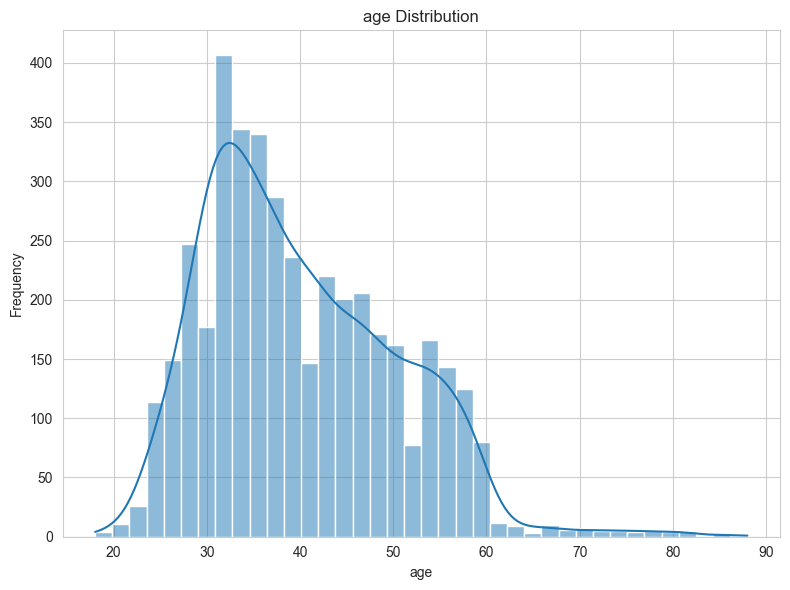

2025-01-01 21:24:08 | Analysis | INFO | Descriptive Statistics for duration:
{
  'count':  4119.0000,
  'mean':   256.7881,
  'std':   254.7037,
  'min':     0.0000,
  '25%':   103.0000,
  '50%':   181.0000,
  '75%':   317.0000,
  'max':  3643.0000,
}


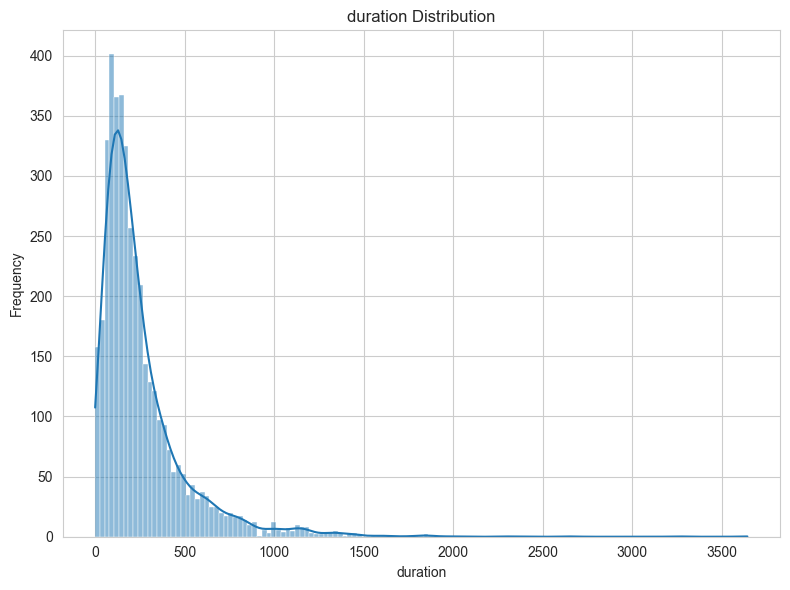

2025-01-01 21:24:08 | Analysis | INFO | Descriptive Statistics for campaign:
{
  'count':  4119.0000,
  'mean':     2.5373,
  'std':     2.5682,
  'min':     1.0000,
  '25%':     1.0000,
  '50%':     2.0000,
  '75%':     3.0000,
  'max':    35.0000,
}


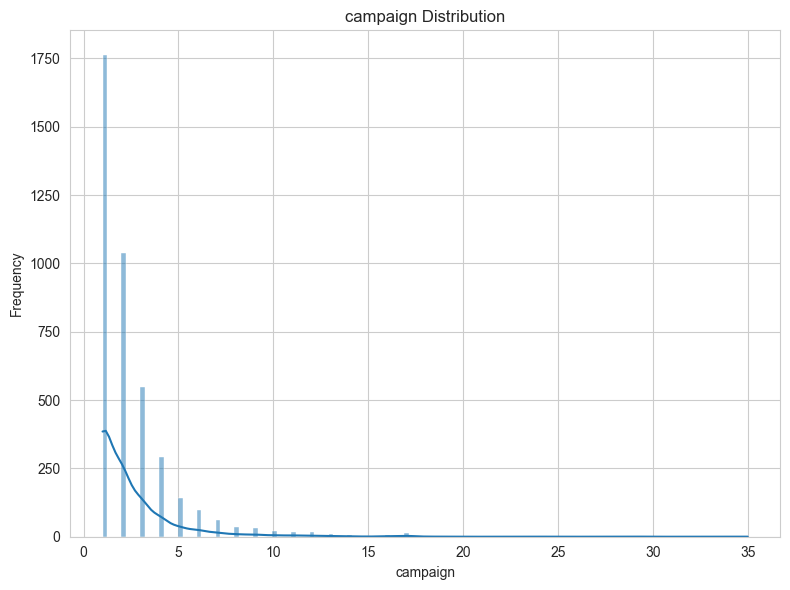

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for pdays:
{
  'count':  4119.0000,
  'mean':   960.4222,
  'std':   191.9228,
  'min':     0.0000,
  '25%':   999.0000,
  '50%':   999.0000,
  '75%':   999.0000,
  'max':   999.0000,
}


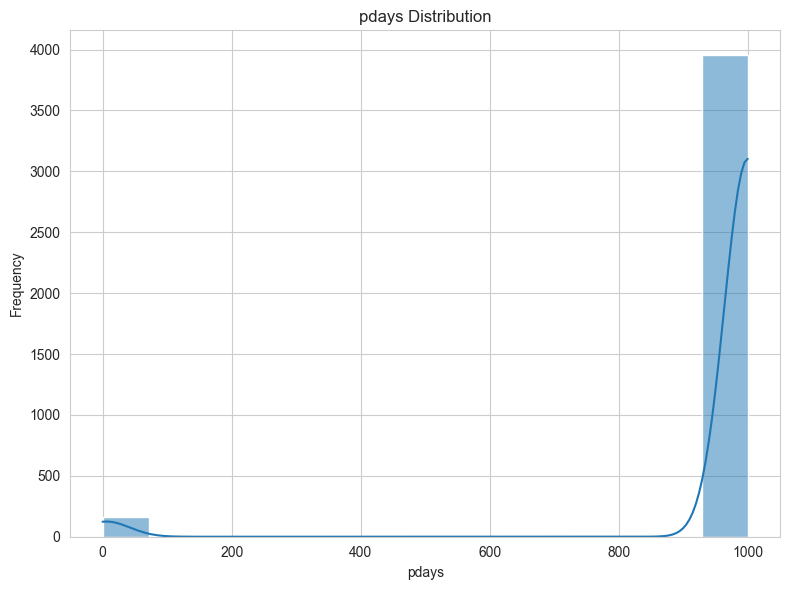

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for previous:
{
  'count':  4119.0000,
  'mean':     0.1903,
  'std':     0.5418,
  'min':     0.0000,
  '25%':     0.0000,
  '50%':     0.0000,
  '75%':     0.0000,
  'max':     6.0000,
}


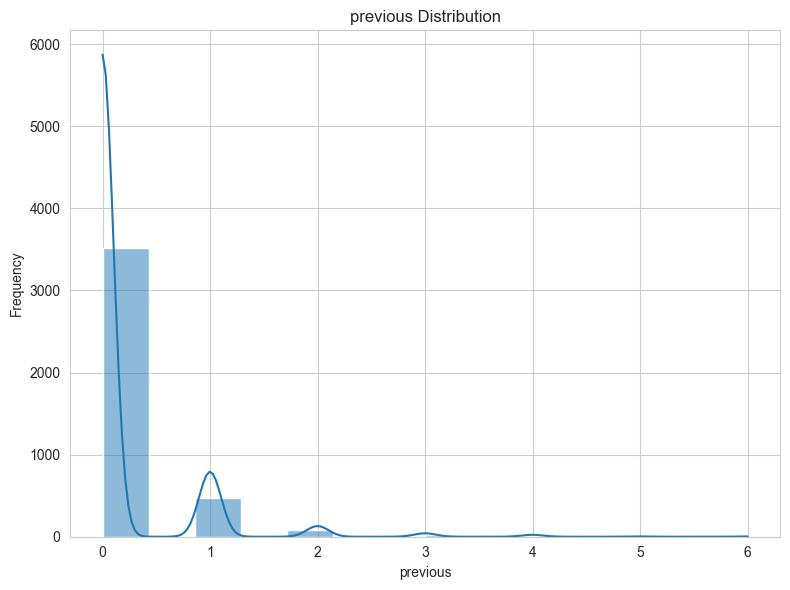

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for emp.var.rate:
{
  'count':  4119.0000,
  'mean':     0.0850,
  'std':     1.5631,
  'min':    -3.4000,
  '25%':    -1.8000,
  '50%':     1.1000,
  '75%':     1.4000,
  'max':     1.4000,
}


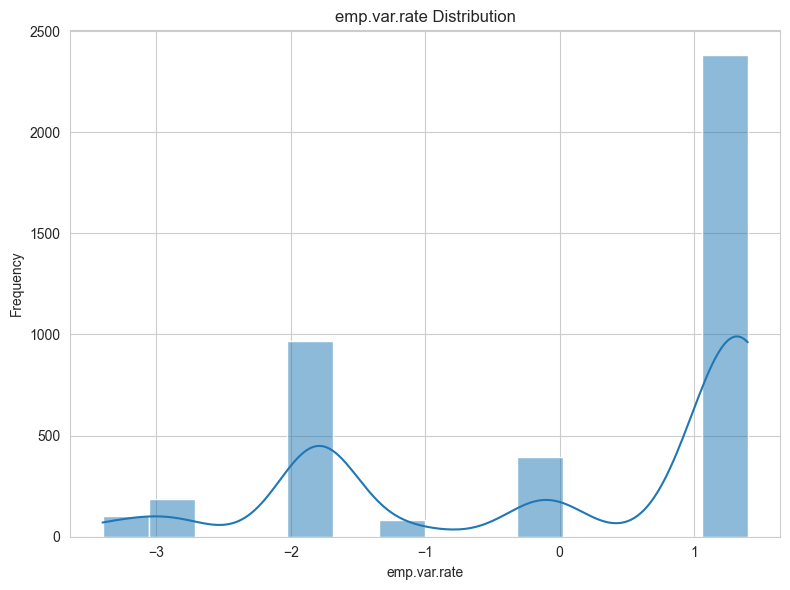

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for cons.price.idx:
{
  'count':  4119.0000,
  'mean':    93.5797,
  'std':     0.5793,
  'min':    92.2010,
  '25%':    93.0750,
  '50%':    93.7490,
  '75%':    93.9940,
  'max':    94.7670,
}


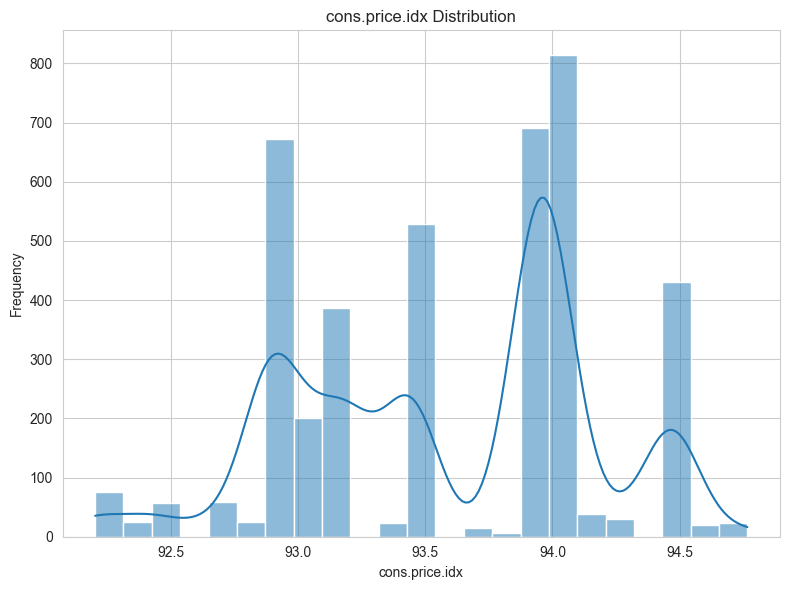

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for cons.conf.idx:
{
  'count':  4119.0000,
  'mean':   -40.4991,
  'std':     4.5946,
  'min':   -50.8000,
  '25%':   -42.7000,
  '50%':   -41.8000,
  '75%':   -36.4000,
  'max':   -26.9000,
}


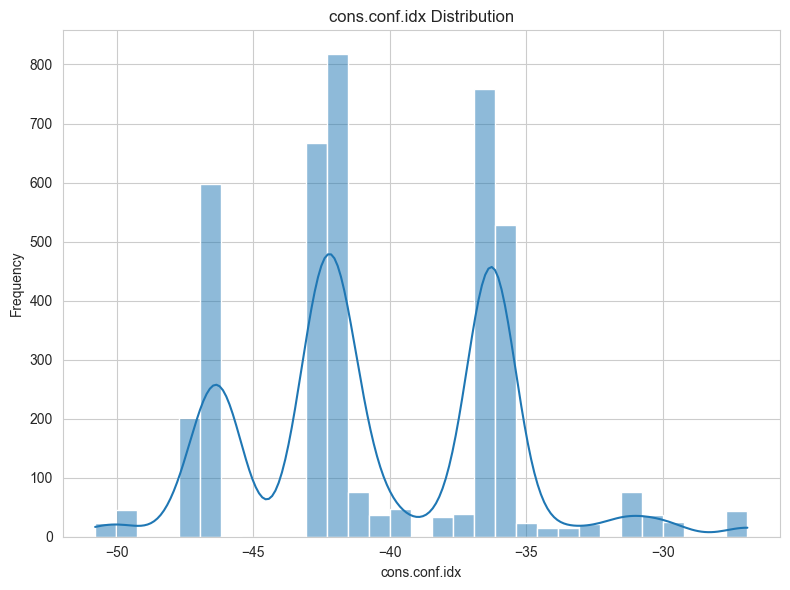

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for euribor3m:
{
  'count':  4119.0000,
  'mean':     3.6214,
  'std':     1.7336,
  'min':     0.6350,
  '25%':     1.3340,
  '50%':     4.8570,
  '75%':     4.9610,
  'max':     5.0450,
}


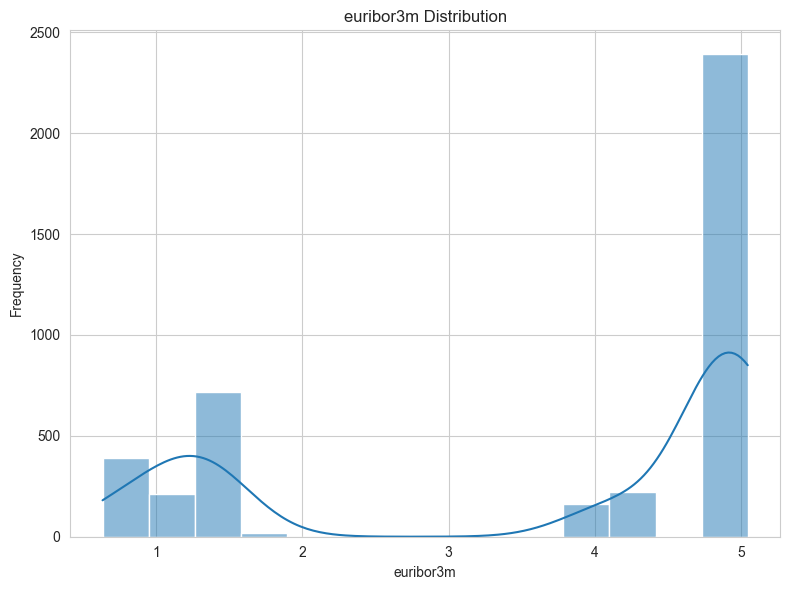

2025-01-01 21:24:09 | Analysis | INFO | Descriptive Statistics for nr.employed:
{
  'count':  4119.0000,
  'mean':  5166.4817,
  'std':    73.6679,
  'min':  4963.6000,
  '25%':  5099.1000,
  '50%':  5191.0000,
  '75%':  5228.1000,
  'max':  5228.1000,
}


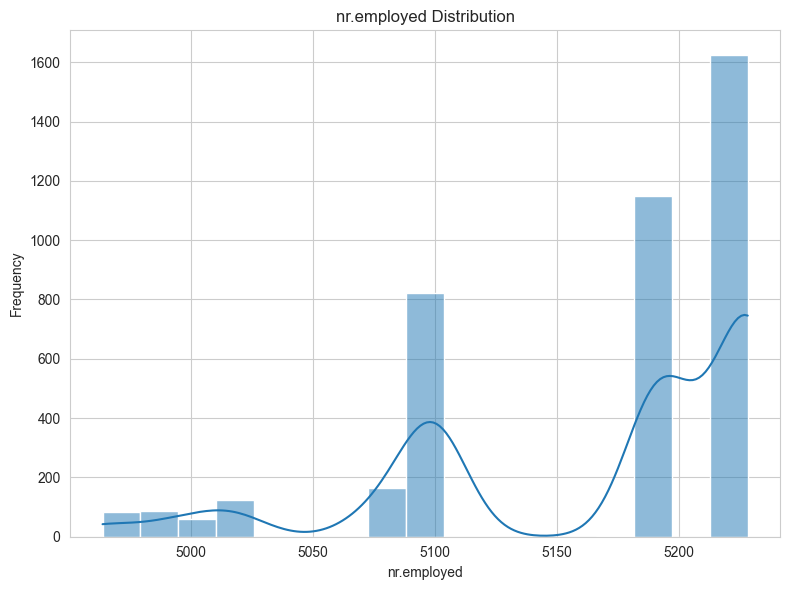

2025-01-01 21:24:09 | Analysis | INFO | 
Distribution for job:
               Count  Percentage
job                             
admin.          1012       24.57
blue-collar      884       21.46
technician       691       16.78
services         393        9.54
management       324        7.87
retired          166        4.03
self-employed    159        3.86
entrepreneur     148        3.59
unemployed       111        2.69
housemaid        110        2.67
student           82        1.99
unknown           39        0.95


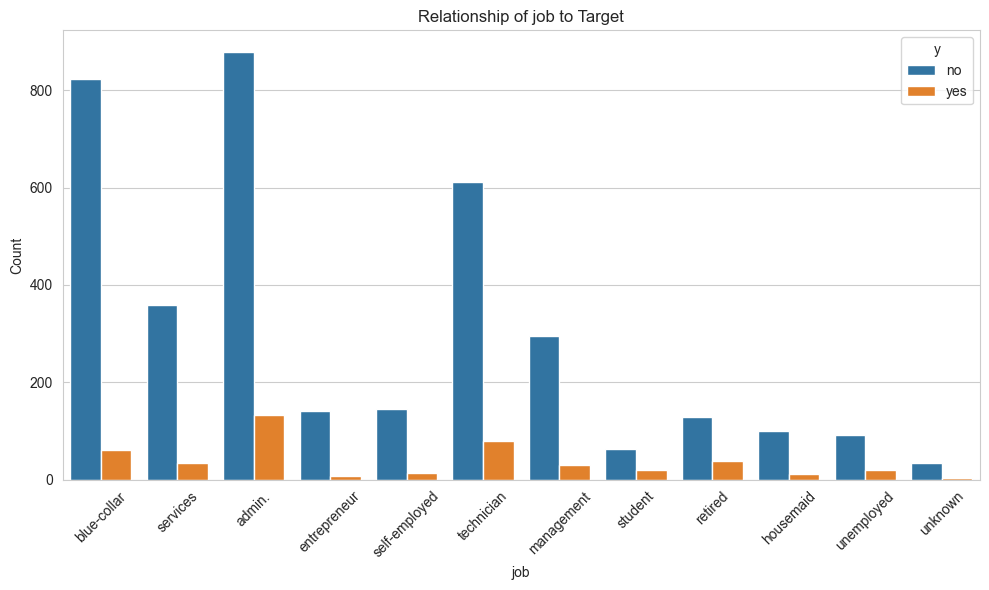

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for marital:
          Count  Percentage
marital                    
married    2509       60.91
single     1153       27.99
divorced    446       10.83
unknown      11        0.27


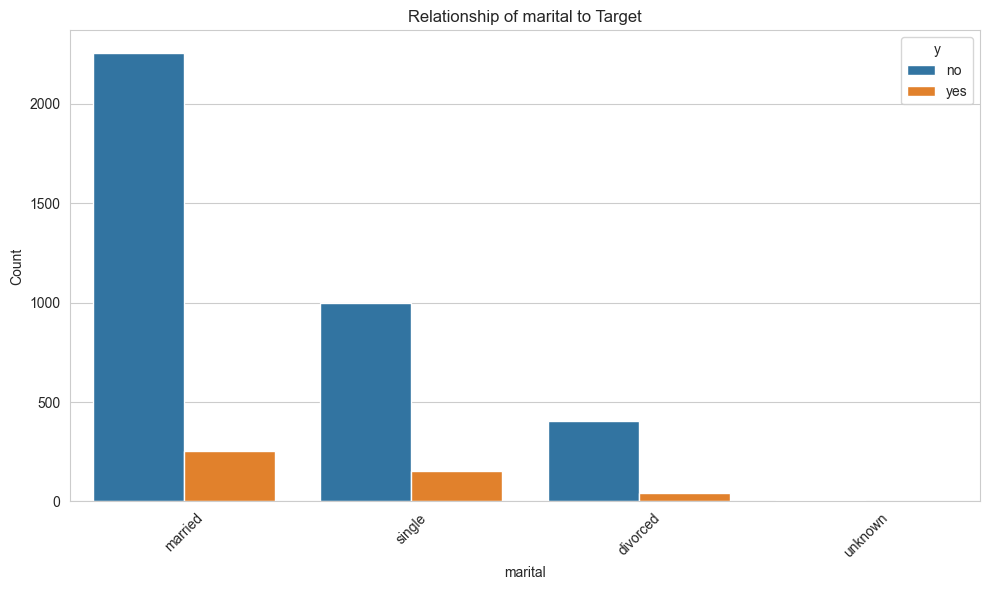

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for education:
                     Count  Percentage
education                             
university.degree     1264       30.69
high.school            921       22.36
basic.9y               574       13.94
professional.course    535       12.99
basic.4y               429       10.42
basic.6y               228        5.54
unknown                167        4.05
illiterate               1        0.02


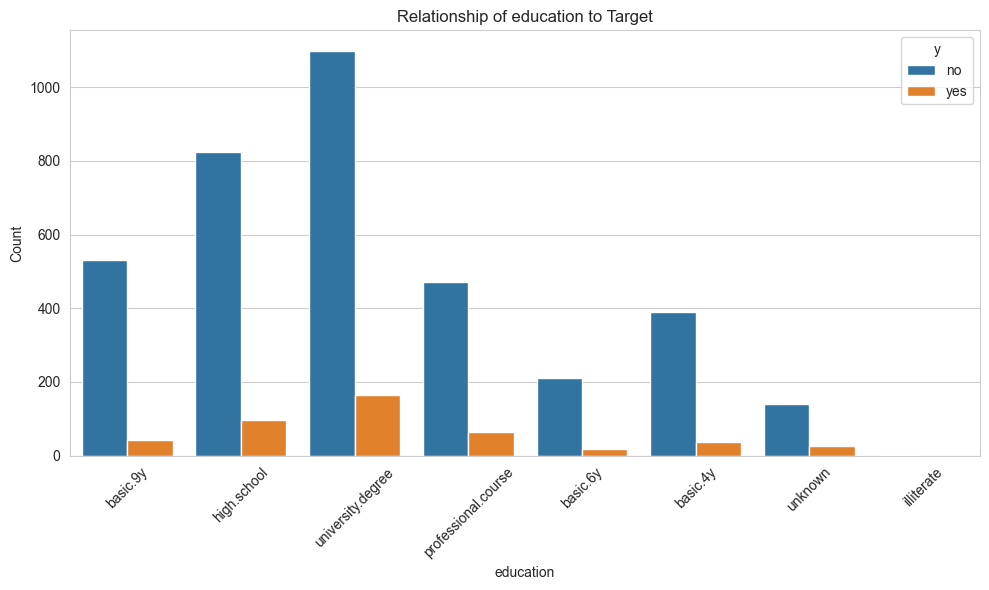

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for default:
         Count  Percentage
default                   
no        3315       80.48
unknown    803       19.50
yes          1        0.02


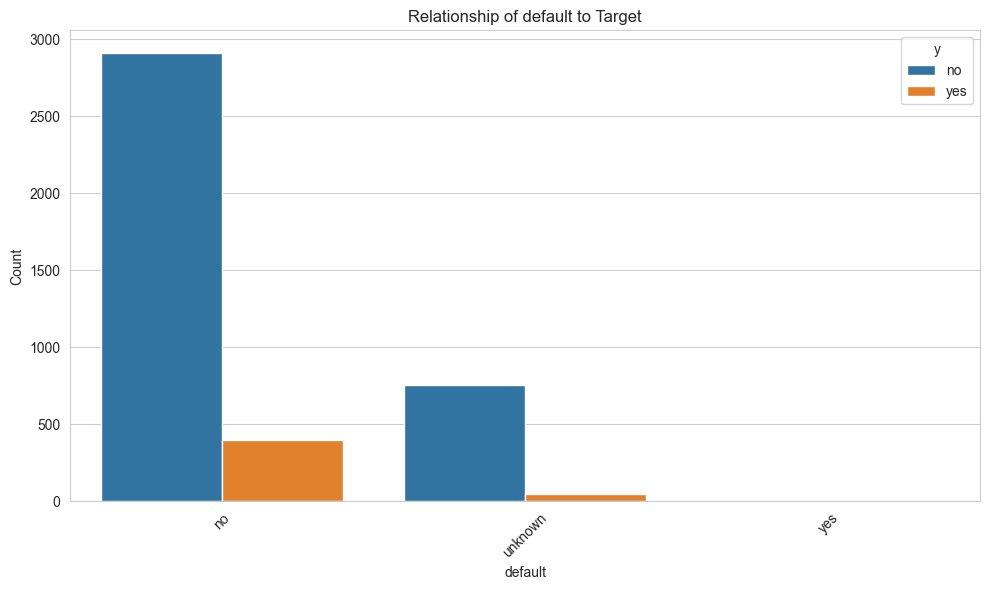

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for housing:
         Count  Percentage
housing                   
yes       2175       52.80
no        1839       44.65
unknown    105        2.55


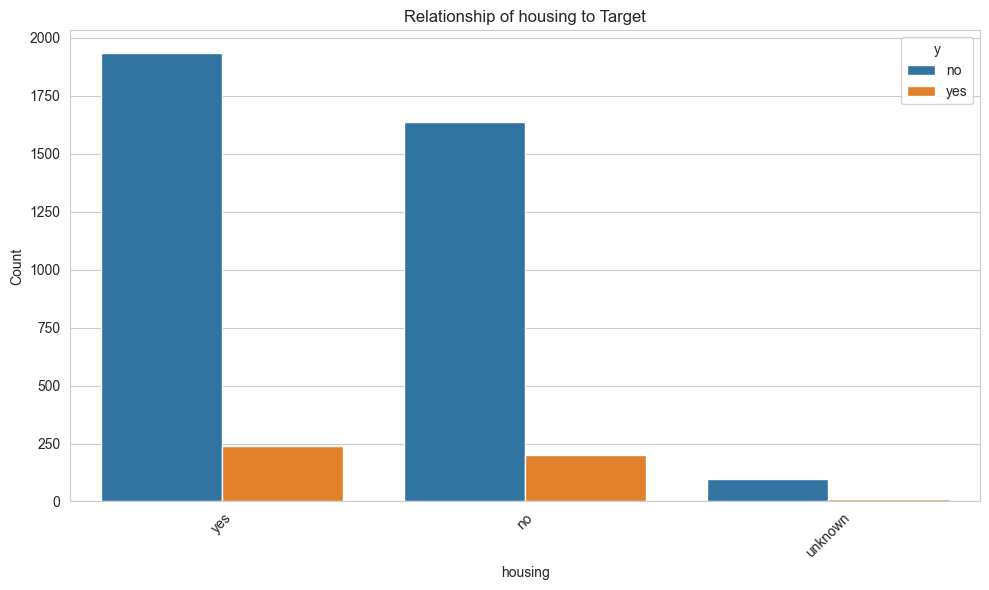

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for loan:
         Count  Percentage
loan                      
no        3349       81.31
yes        665       16.14
unknown    105        2.55


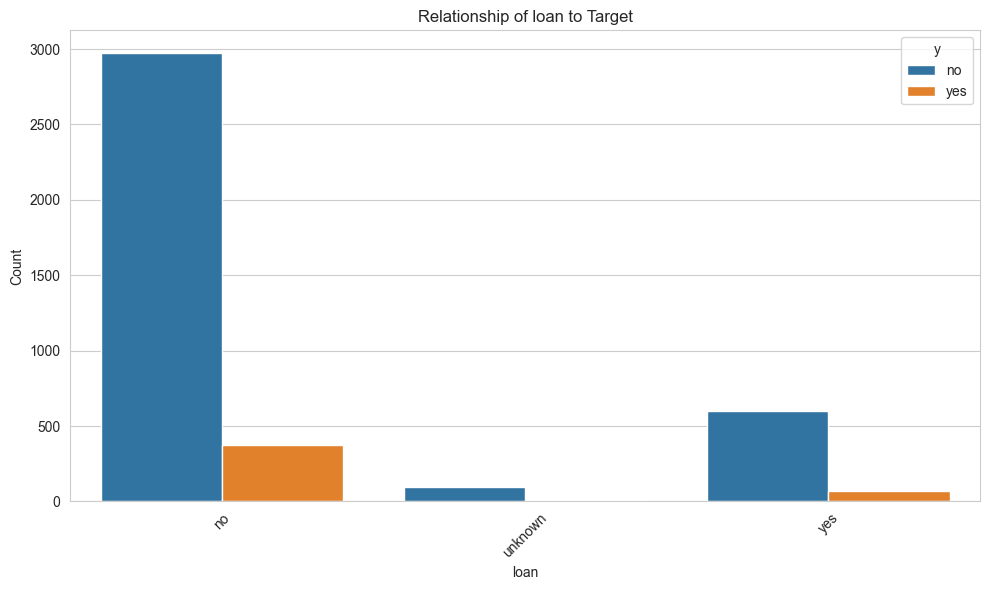

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for contact:
           Count  Percentage
contact                     
cellular    2652       64.38
telephone   1467       35.62


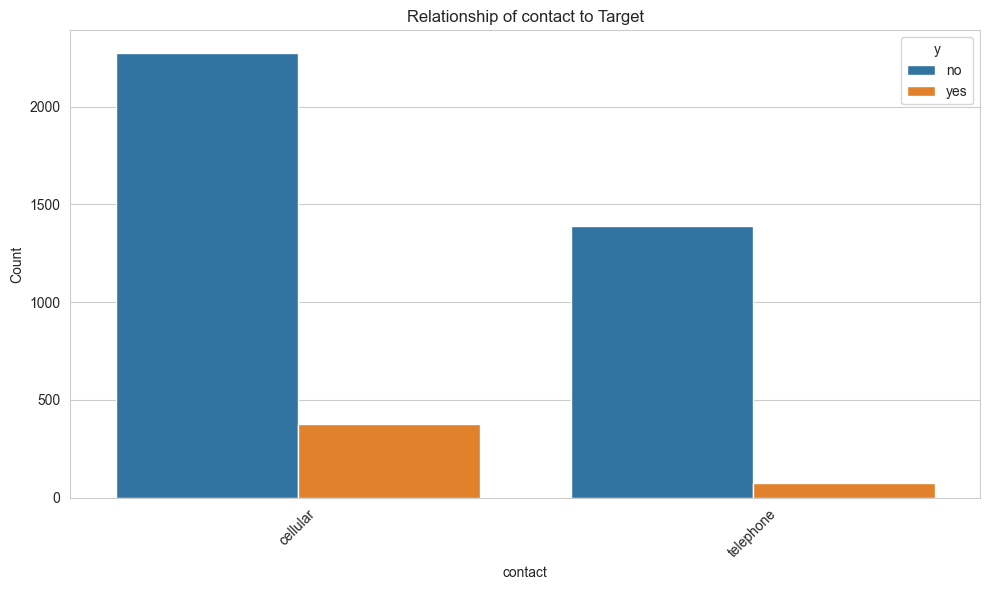

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for month:
       Count  Percentage
month                   
may     1378       33.45
jul      711       17.26
aug      636       15.44
jun      530       12.87
nov      446       10.83
apr      215        5.22
oct       69        1.68
sep       64        1.55
mar       48        1.17
dec       22        0.53


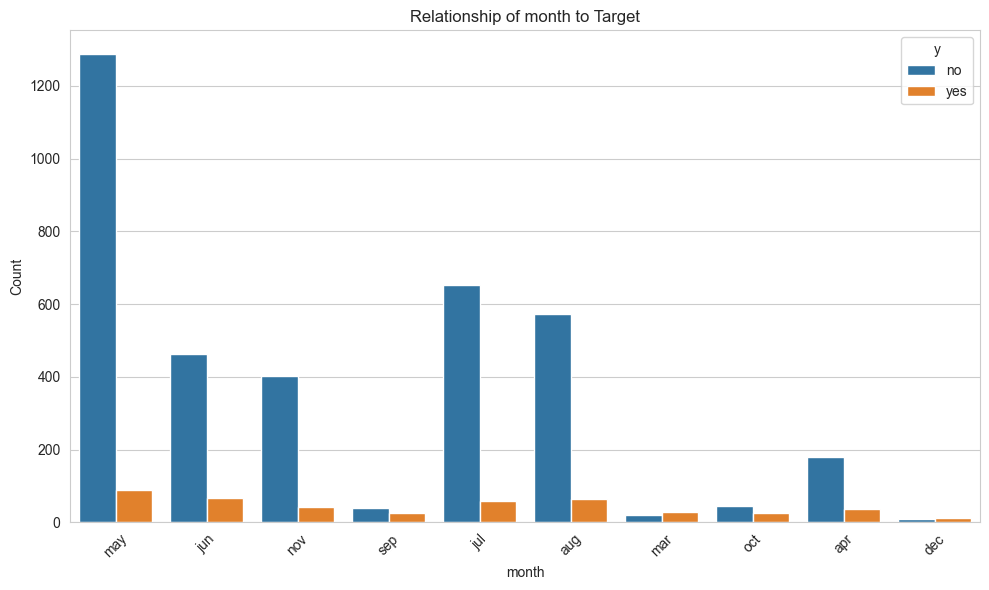

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for day_of_week:
             Count  Percentage
day_of_week                   
thu            860       20.88
mon            855       20.76
tue            841       20.42
wed            795       19.30
fri            768       18.65


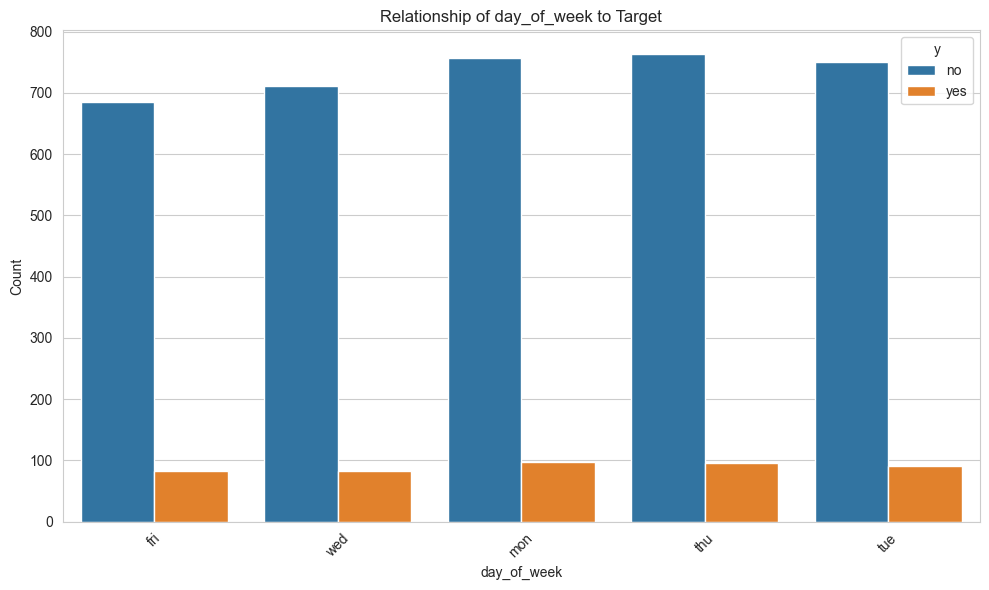

2025-01-01 21:24:10 | Analysis | INFO | 
Distribution for poutcome:
             Count  Percentage
poutcome                      
nonexistent   3523       85.53
failure        454       11.02
success        142        3.45


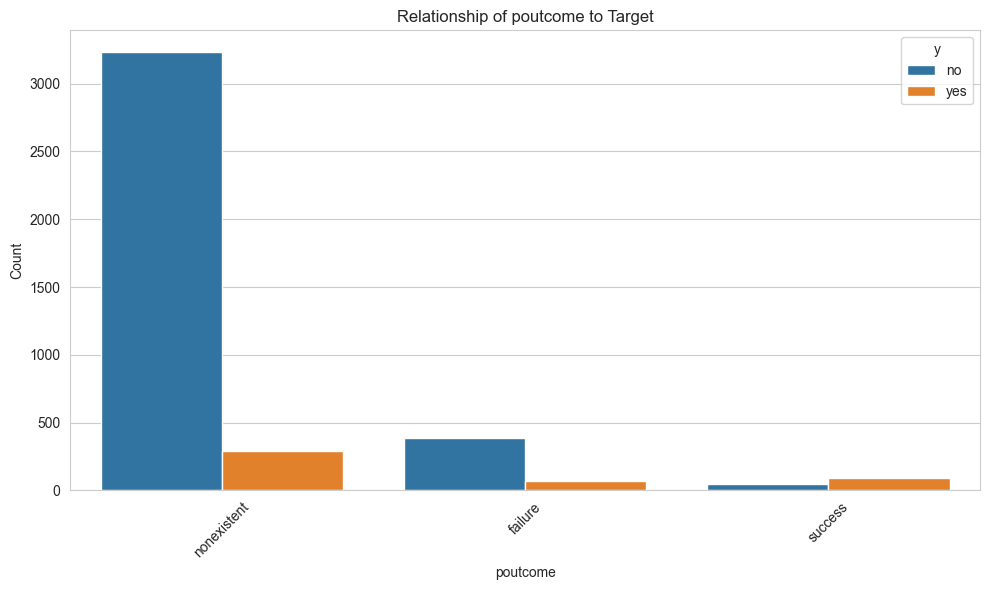

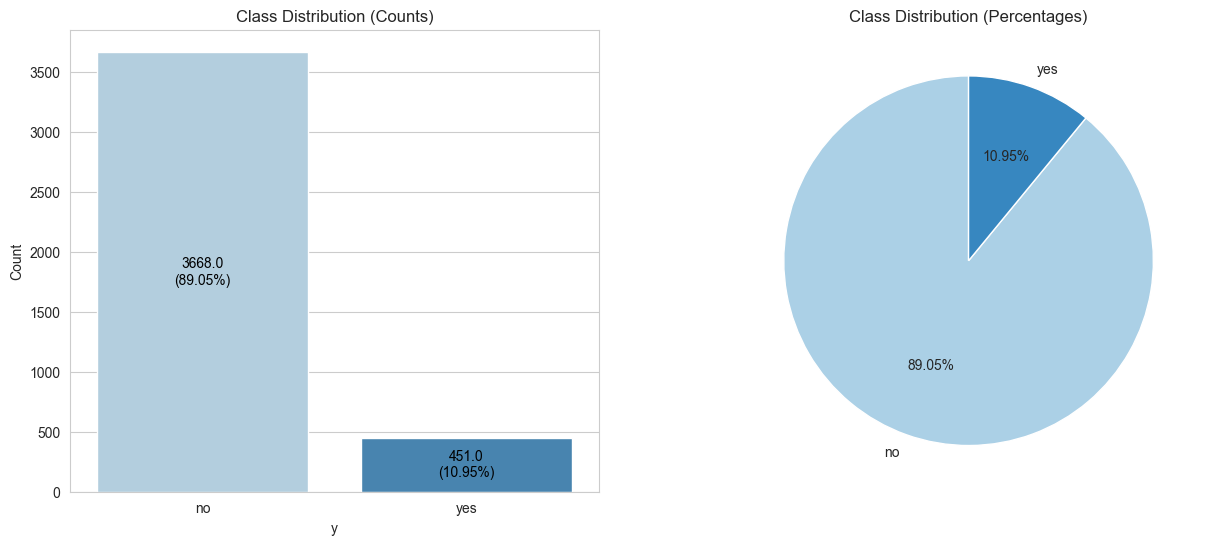

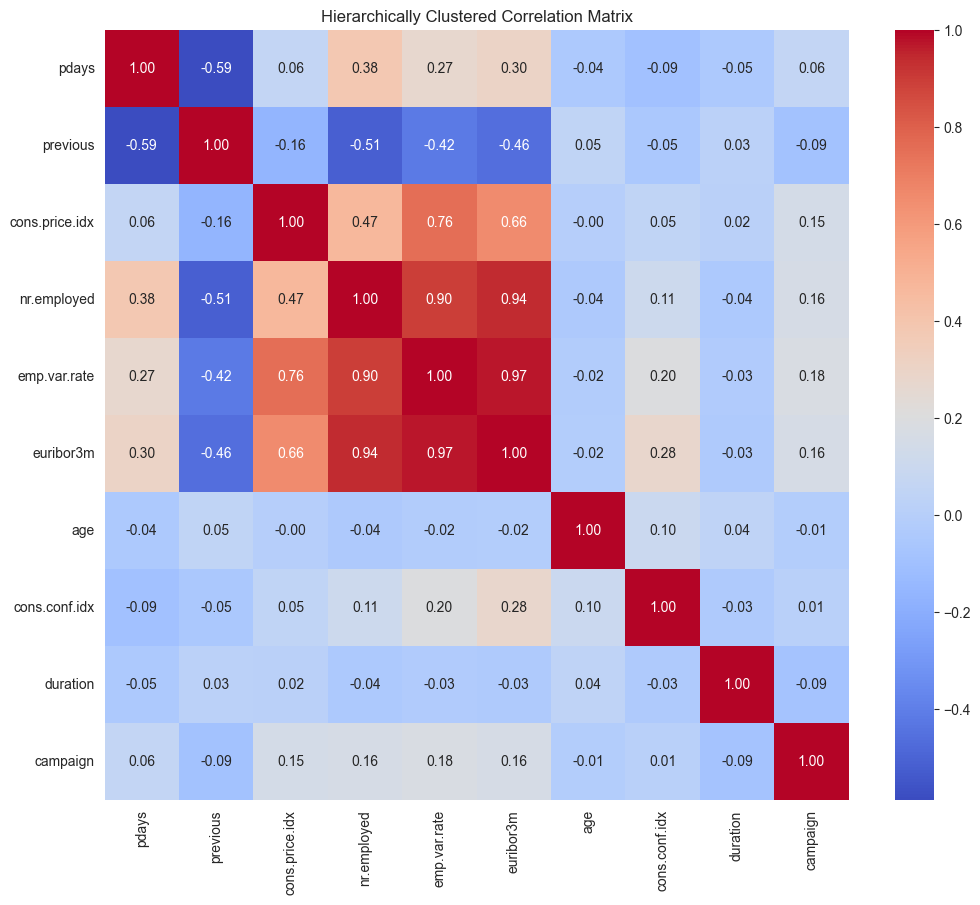

({'age': {'count': 4119.0,
   'mean': 40.11361981063365,
   'std': 10.313361547199813,
   'min': 18.0,
   '25%': 32.0,
   '50%': 38.0,
   '75%': 47.0,
   'max': 88.0},
  'duration': {'count': 4119.0,
   'mean': 256.7880553532411,
   'std': 254.70373612073678,
   'min': 0.0,
   '25%': 103.0,
   '50%': 181.0,
   '75%': 317.0,
   'max': 3643.0},
  'campaign': {'count': 4119.0,
   'mean': 2.537266326778344,
   'std': 2.568159237578138,
   'min': 1.0,
   '25%': 1.0,
   '50%': 2.0,
   '75%': 3.0,
   'max': 35.0},
  'pdays': {'count': 4119.0,
   'mean': 960.4221898519058,
   'std': 191.92278580077644,
   'min': 0.0,
   '25%': 999.0,
   '50%': 999.0,
   '75%': 999.0,
   'max': 999.0},
  'previous': {'count': 4119.0,
   'mean': 0.19033746054867687,
   'std': 0.5417883234290308,
   'min': 0.0,
   '25%': 0.0,
   '50%': 0.0,
   '75%': 0.0,
   'max': 6.0},
  'emp.var.rate': {'count': 4119.0,
   'mean': 0.08497208060208788,
   'std': 1.5631144559116763,
   'min': -3.4,
   '25%': -1.8,
   '50%': 1.1,

In [30]:
# Basic Analysis
analyze_dataset(logger, marketing_data, target_column='y', output_path=OUTPUT_PATH)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective of the Portuguese bank's marketing machine learning initiative is focused on optimizing their direct marketing campaigns for term deposits with two key goals:

#### Primary Objectives
**Resource Optimization**: To increase the efficiency of telemarketing campaigns by reducing the number of client contacts needed to achieve successful outcomes.

**Conversion Enhancement**: To maintain or improve the success rate of term deposit subscriptions while minimizing resource expenditure.

#### Strategic Benefits
The implementation of machine learning aims to:
- Identify customers with higher likelihood of subscribing to term deposits
- Reduce unnecessary phone calls and associated costs
- Maximize the productive use of contact center resources
- Improve the allocation of human effort and time

This data-driven approach enables the bank to make more targeted marketing decisions, ultimately leading to more cost-effective campaigns while maintaining or improving their conversion rates.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [31]:
# Replace "unknown" with NaN
marketing_data.replace('unknown', np.nan, inplace=True)

# Drop "duration" if it exists
if 'duration' in marketing_data.columns:
    marketing_data.drop(columns=['duration'], inplace=True)

In [32]:
# Feature Engineering
y = marketing_data['y'].apply(lambda val: 1 if val == 'yes' else 0)
X = marketing_data.drop(columns=['y'])

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

# Balance Classes (upsample minority)
df_temp = pd.concat([X, y], axis=1)
df_majority = df_temp[df_temp['y'] == 0]
df_minority = df_temp[df_temp['y'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=RANDOM_STATE
)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
y_upsampled = df_upsampled['y']
X_upsampled = df_upsampled.drop(columns=['y'])

# Encode & Scale
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])
X_transformed = preprocessor.fit_transform(X_upsampled)

# Extract feature names for Perm. Importance & PDP
ohe = preprocessor.named_transformers_['cat']
encoded_cat_features = list(ohe.get_feature_names_out(categorical_cols))
feature_names = list(numeric_cols) + encoded_cat_features

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [33]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed,
    y_upsampled,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_upsampled
)

In [34]:
# Log shapes and distributions
logger.info(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
logger.info(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")
logger.info("\nClass distribution in training set:")
logger.info(pd.Series(y_train).value_counts(normalize=True).to_string())
logger.info("\nClass distribution in test set:")
logger.info(pd.Series(y_test).value_counts(normalize=True).to_string())

2025-01-01 21:24:11 | Analysis | INFO | Training set shape: X_train (5868, 46), y_train (5868,)
2025-01-01 21:24:11 | Analysis | INFO | Test set shape: X_test (1468, 46), y_test (1468,)
2025-01-01 21:24:11 | Analysis | INFO | 
Class distribution in training set:
2025-01-01 21:24:11 | Analysis | INFO | y
1    0.5
0    0.5
2025-01-01 21:24:11 | Analysis | INFO | 
Class distribution in test set:
2025-01-01 21:24:11 | Analysis | INFO | y
1    0.5
0    0.5


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [35]:
# Baseline Model
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_dummy)

In [36]:
# Log accuracy metrics
logger.info(f"\nBaseline Model Performance:")
logger.info(f"Accuracy Score: {baseline_accuracy:.4f}")
logger.info("\nClassification Report:")
logger.info(f"\n{classification_report(y_test, y_pred_dummy)}")

2025-01-01 21:24:11 | Analysis | INFO | 
Baseline Model Performance:
2025-01-01 21:24:11 | Analysis | INFO | Accuracy Score: 0.5000
2025-01-01 21:24:11 | Analysis | INFO | 
Classification Report:
2025-01-01 21:24:11 | Analysis | INFO | 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       734
           1       0.00      0.00      0.00       734

    accuracy                           0.50      1468
   macro avg       0.25      0.50      0.33      1468
weighted avg       0.25      0.50      0.33      1468



### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

2025-01-01 21:24:11 | Analysis | INFO | Training Logistic Regression ...
2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.7011    0.8597    0.7723       734
           1     0.8187    0.6335    0.7143       734

    accuracy                         0.7466      1468
   macro avg     0.7599    0.7466    0.7433      1468
weighted avg     0.7599    0.7466    0.7433      1468

2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression Train Accuracy: 0.7384
2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression Test Accuracy: 0.7466
2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression Precision: 0.8187
2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression Recall: 0.6335
2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression F1 Score: 0.7143
2025-01-01 21:24:11 | Analysis | INFO | Logistic Regression ROC AUC: 0.7966


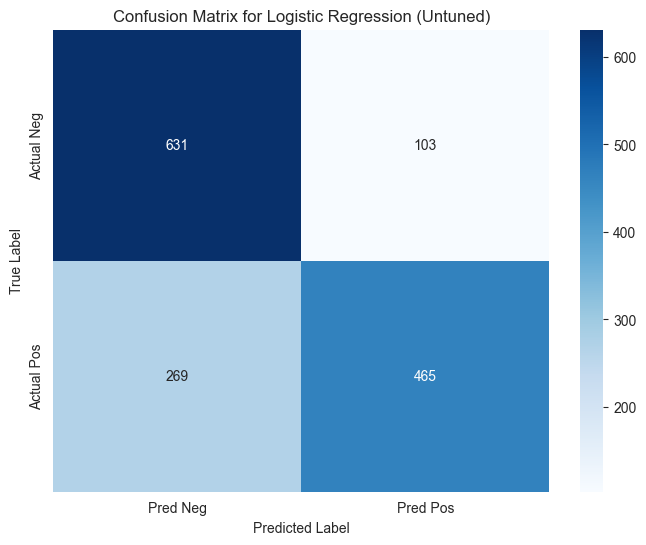

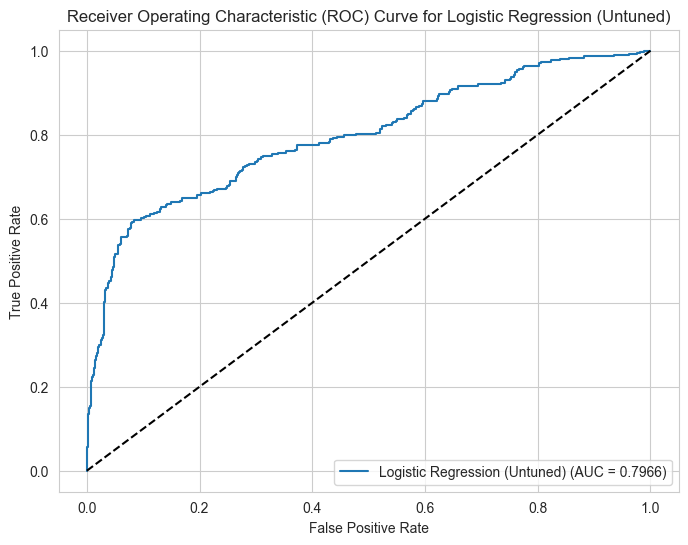

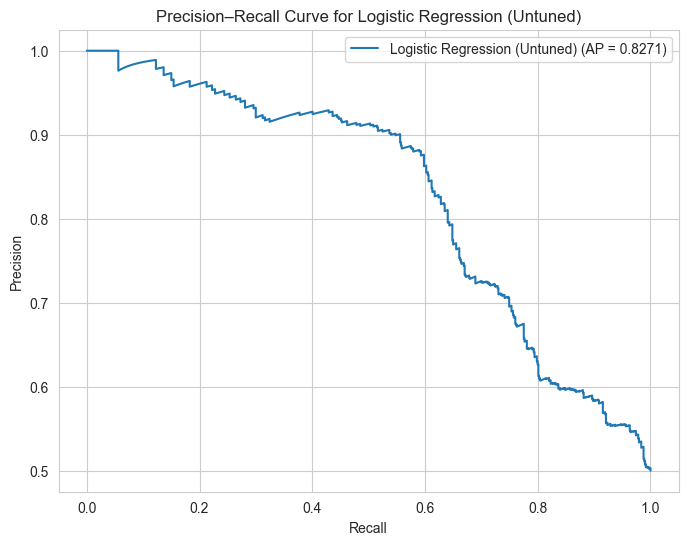

In [37]:
# Train a single example model
logistic_results = train_model(X_train, X_test, y_train, y_test, model_name='Logistic Regression')

### Problem 9: Score the Model

What is the accuracy of your model?

Logistic Regression Train Accuracy: 0.7384

Logistic Regression Test Accuracy: 0.7466

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

2025-01-01 21:24:12 | Analysis | INFO | Training Logistic Regression ...
2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.7011    0.8597    0.7723       734
           1     0.8187    0.6335    0.7143       734

    accuracy                         0.7466      1468
   macro avg     0.7599    0.7466    0.7433      1468
weighted avg     0.7599    0.7466    0.7433      1468

2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression Train Accuracy: 0.7384
2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression Test Accuracy: 0.7466
2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression Precision: 0.8187
2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression Recall: 0.6335
2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression F1 Score: 0.7143
2025-01-01 21:24:12 | Analysis | INFO | Logistic Regression ROC AUC: 0.7966


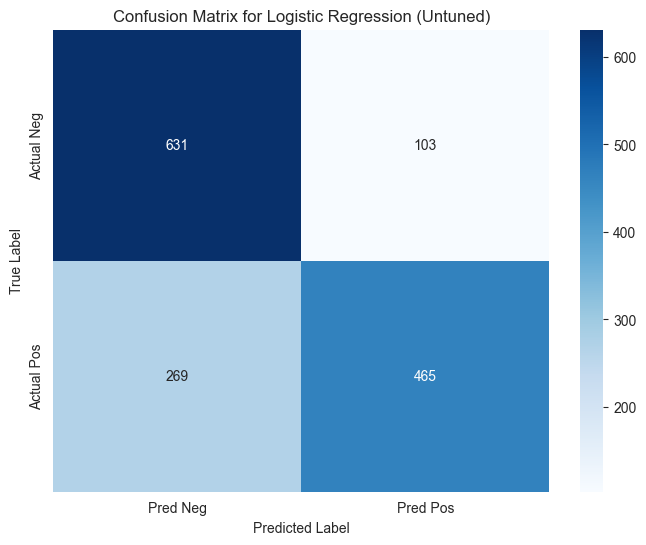

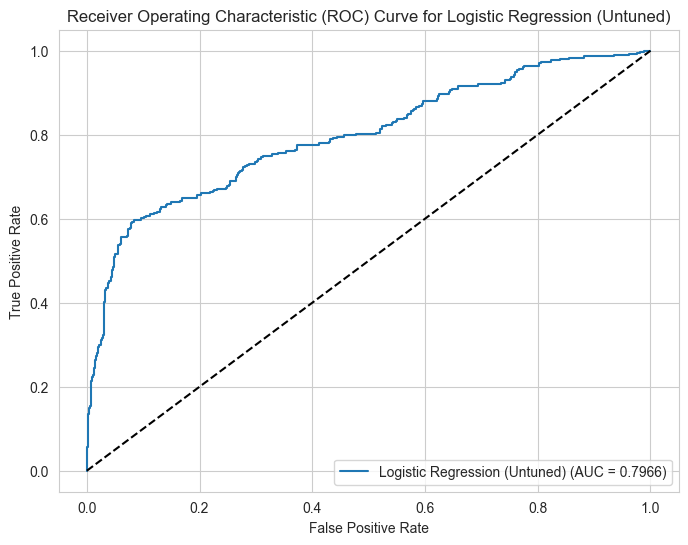

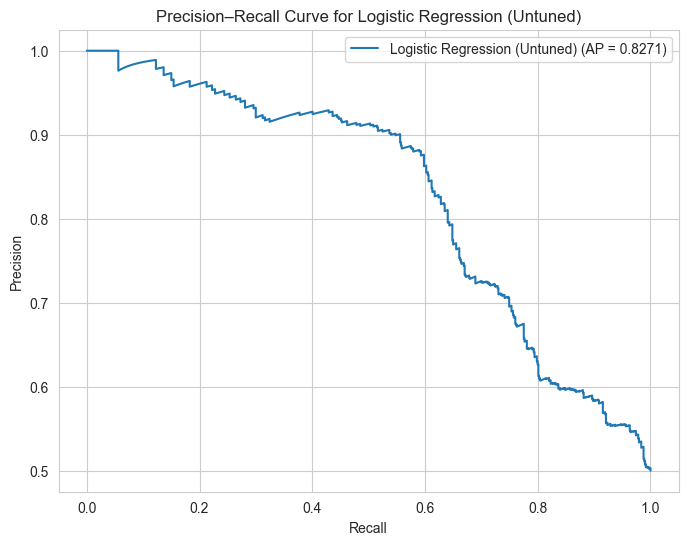

2025-01-01 21:24:12 | Analysis | INFO | Training Decision Tree ...
2025-01-01 21:24:12 | Analysis | INFO | Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8910    0.9424       734
           1     0.9017    1.0000    0.9483       734

    accuracy                         0.9455      1468
   macro avg     0.9509    0.9455    0.9453      1468
weighted avg     0.9509    0.9455    0.9453      1468

2025-01-01 21:24:12 | Analysis | INFO | Decision Tree Train Accuracy: 0.9997
2025-01-01 21:24:12 | Analysis | INFO | Decision Tree Test Accuracy: 0.9455
2025-01-01 21:24:12 | Analysis | INFO | Decision Tree Precision: 0.9017
2025-01-01 21:24:12 | Analysis | INFO | Decision Tree Recall: 1.0000
2025-01-01 21:24:12 | Analysis | INFO | Decision Tree F1 Score: 0.9483
2025-01-01 21:24:12 | Analysis | INFO | Decision Tree ROC AUC: 0.9458


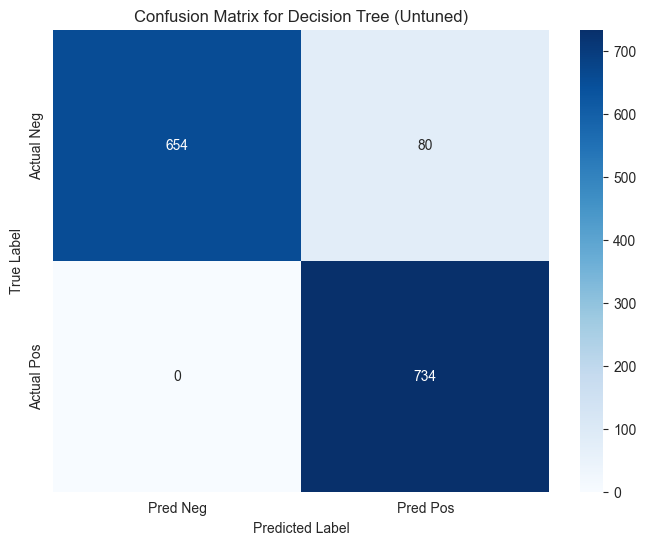

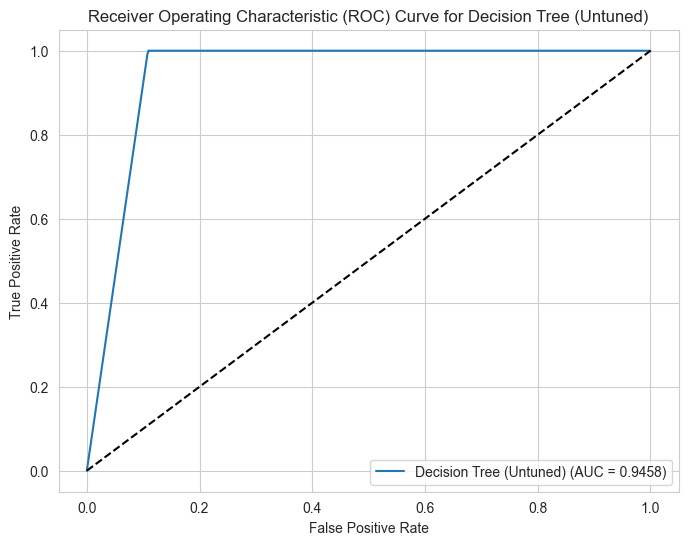

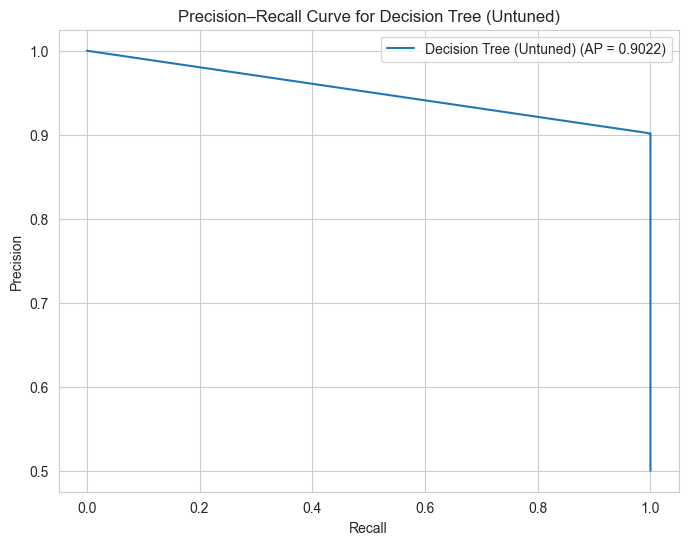

2025-01-01 21:24:12 | Analysis | INFO | Training KNN ...
2025-01-01 21:24:12 | Analysis | INFO | KNN Classification Report:
              precision    recall  f1-score   support

           0     0.9680    0.7425    0.8404       734
           1     0.7912    0.9755    0.8737       734

    accuracy                         0.8590      1468
   macro avg     0.8796    0.8590    0.8571      1468
weighted avg     0.8796    0.8590    0.8571      1468

2025-01-01 21:24:12 | Analysis | INFO | KNN Train Accuracy: 0.9008
2025-01-01 21:24:12 | Analysis | INFO | KNN Test Accuracy: 0.8590
2025-01-01 21:24:12 | Analysis | INFO | KNN Precision: 0.7912
2025-01-01 21:24:12 | Analysis | INFO | KNN Recall: 0.9755
2025-01-01 21:24:12 | Analysis | INFO | KNN F1 Score: 0.8737
2025-01-01 21:24:12 | Analysis | INFO | KNN ROC AUC: 0.9372


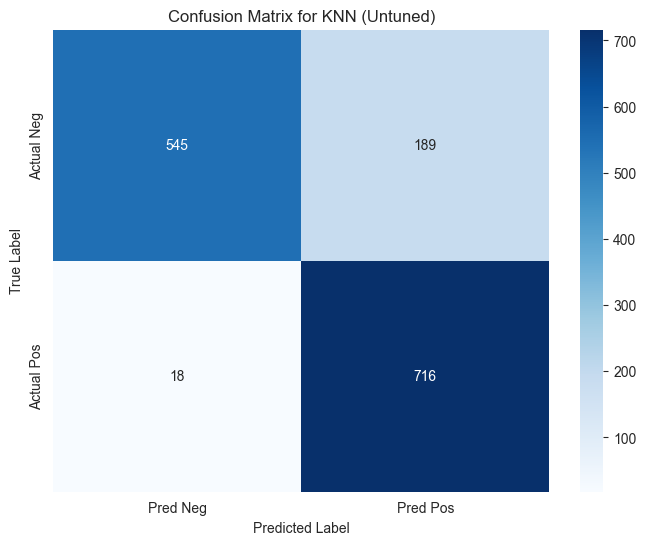

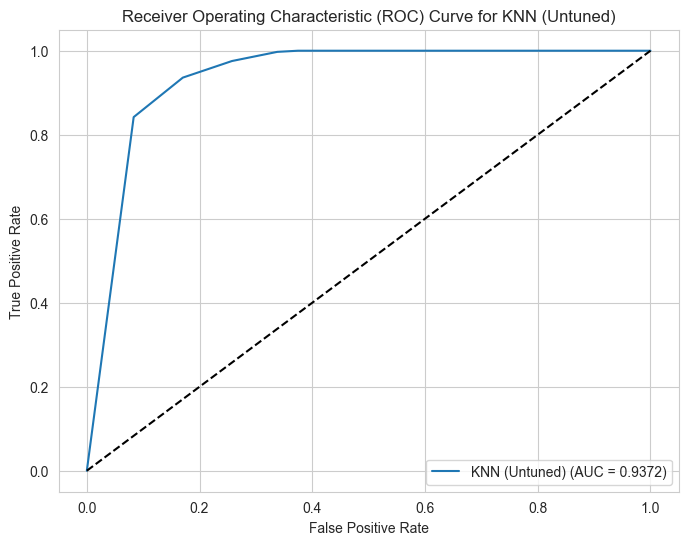

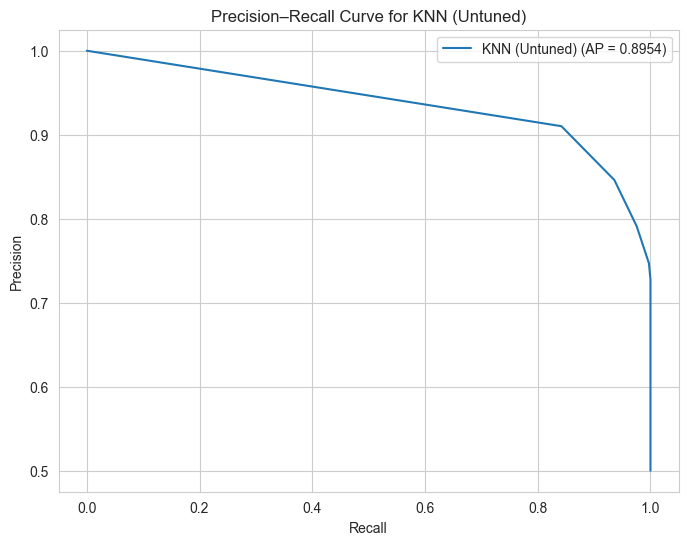

2025-01-01 21:24:13 | Analysis | INFO | Training SVM ...


In [ ]:
# Compare Multiple Models (Untuned)
model_names = ['Logistic Regression', 'Decision Tree', 'KNN', 'SVM']
untuned_models = []
for m_name in model_names:
    result = train_model(X_train, X_test, y_train, y_test, model_name=m_name)
    untuned_models.append([
        m_name,
        f"{result['train_time']:.2f}",
        f"{result['train_accuracy']:.4f}",
        f"{result['test_accuracy']:.4f}",
        f"{result['precision']:.4f}",
        f"{result['recall']:.4f}",
        f"{result['f1_score']:.4f}",
        f"{result['roc_auc']:.4f}"
    ])

untuned_df = pd.DataFrame(
    untuned_models,
    columns=[
        'Model', 'Train Time (s)', 'Train Accuracy', 'Test Accuracy',
        'Precision', 'Recall', 'F1 Score', 'ROC AUC'
    ]
)

logger.info("\n=== Untuned Model Comparison ===")
logger.info("### Comparison Table (Untuned)\n" + untuned_df.to_markdown(index=False))

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

2025-01-01 20:53:04 | Analysis | INFO | 
Starting hyperparameter tuning for Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

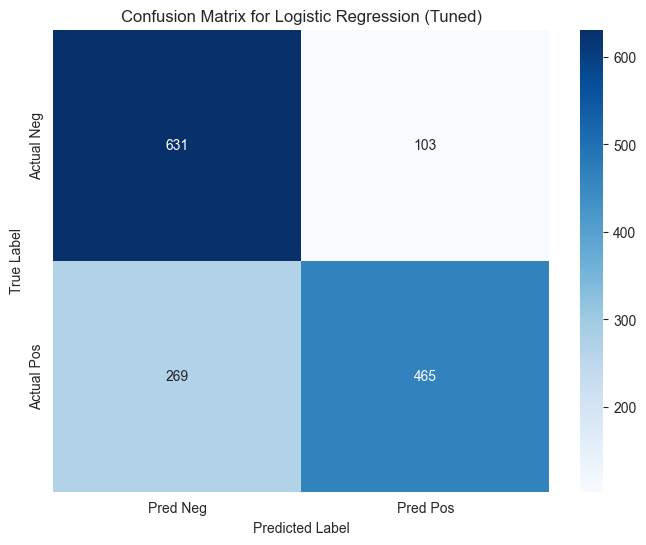

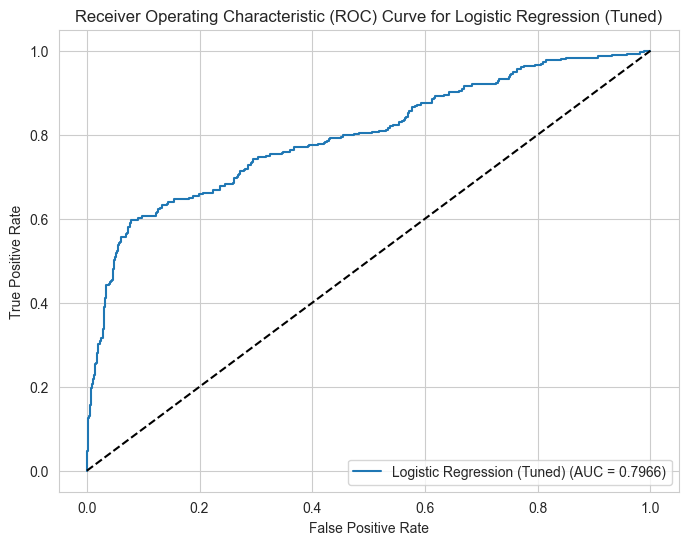

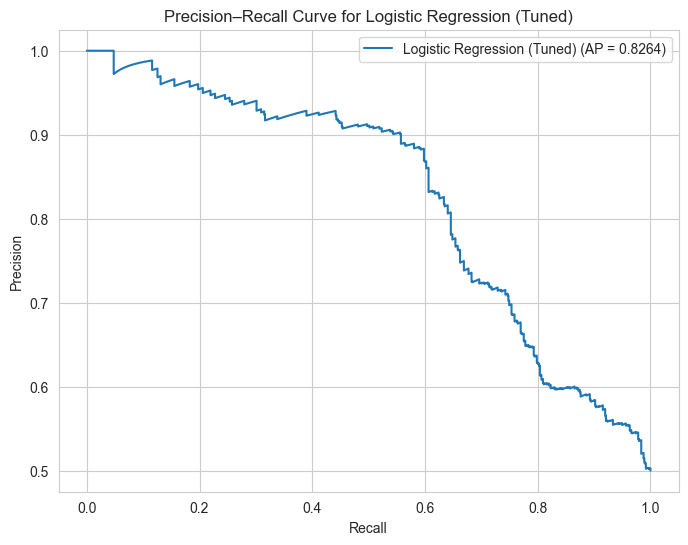

2025-01-01 20:53:12 | Analysis | INFO | Best Params for Logistic Regression: {'C': 10, 'l1_ratio': 0.9, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
2025-01-01 20:53:12 | Analysis | INFO | Train Accuracy: 0.7391
2025-01-01 20:53:12 | Analysis | INFO | Test Accuracy: 0.7466
2025-01-01 20:53:12 | Analysis | INFO | Test ROC AUC: 0.7966
2025-01-01 20:53:12 | Analysis | INFO | GridSearch took 8.02s
2025-01-01 20:53:18 | Analysis | INFO | Cross-Val Accuracy (Training) for Logistic Regression: 0.7377 ± 0.0090
2025-01-01 20:53:18 | Analysis | INFO | 
Analyzing Permutation Feature Importance for Logistic Regression (Tuned)...
2025-01-01 20:53:18 | Analysis | INFO | Top 10 Most Important Features for Logistic Regression (Tuned):
2025-01-01 20:53:18 | Analysis | INFO | 
| feature           |   importance_mean |   importance_std |
|:------------------|------------------:|-----------------:|
| emp.var.rate      |        0.264441   |       0.0214222  |
| cons.price.idx    |        0.

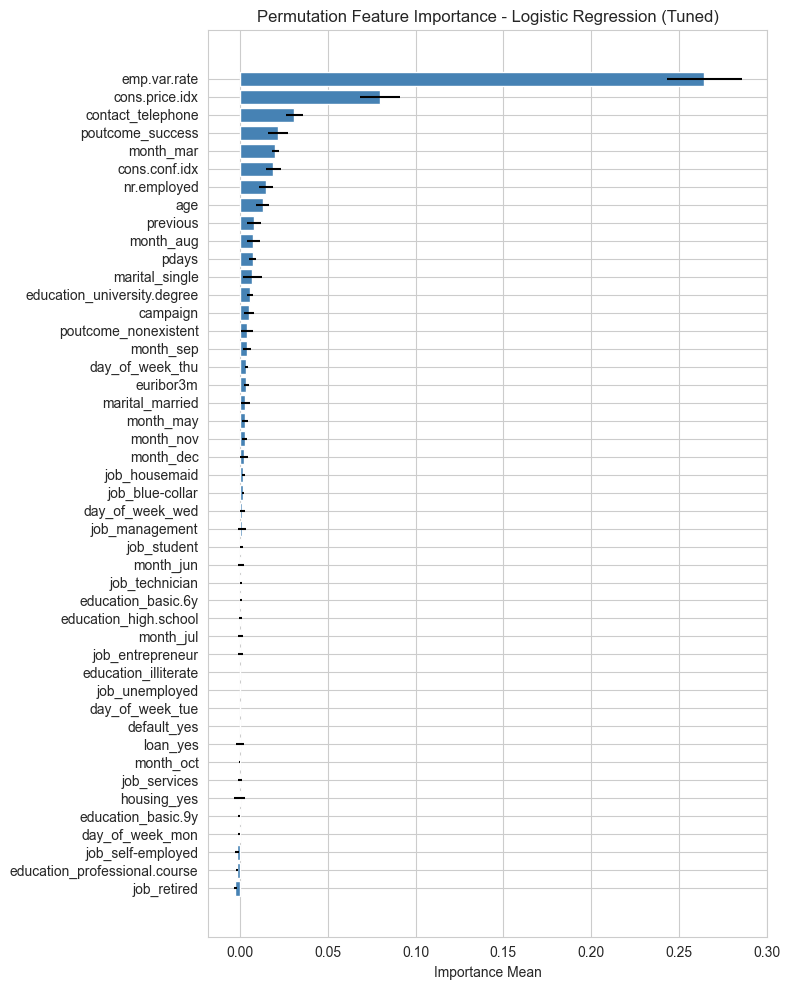

2025-01-01 20:53:19 | Analysis | INFO | 
Generating Partial Dependence Plots for Logistic Regression (Tuned)...


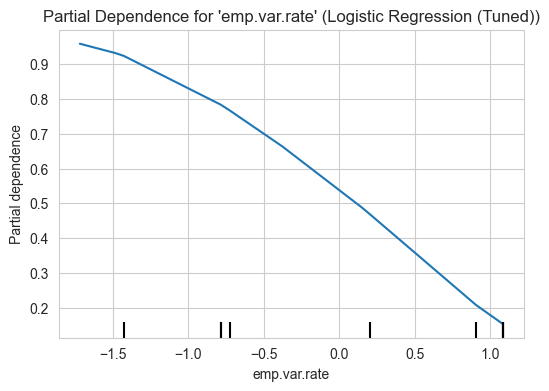

2025-01-01 20:53:19 | Analysis | INFO | PDP for feature 'emp.var.rate' saved as output/pdp_Logistic_Regression_Tuned_emp.var.rate.png


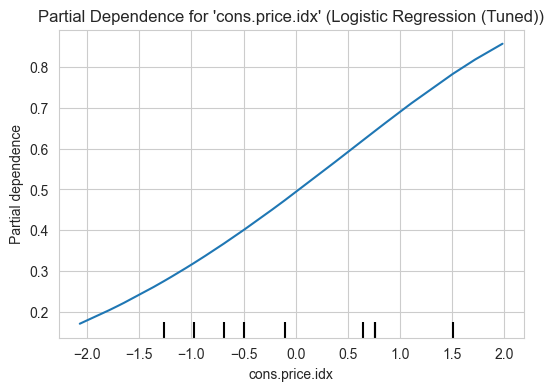

2025-01-01 20:53:19 | Analysis | INFO | PDP for feature 'cons.price.idx' saved as output/pdp_Logistic_Regression_Tuned_cons.price.idx.png
2025-01-01 20:53:19 | Analysis | WARNING | Could not compute PDP for 'contact_telephone' (possibly no variation or model limitation): cannot reshape array of size 1 into shape (2)
2025-01-01 20:53:19 | Analysis | WARNING | Could not compute PDP for 'poutcome_success' (possibly no variation or model limitation): cannot reshape array of size 1 into shape (2)
2025-01-01 20:53:19 | Analysis | WARNING | Could not compute PDP for 'month_mar' (possibly no variation or model limitation): cannot reshape array of size 1 into shape (2)
2025-01-01 20:53:19 | Analysis | INFO | 
Starting hyperparameter tuning for Decision Tree...


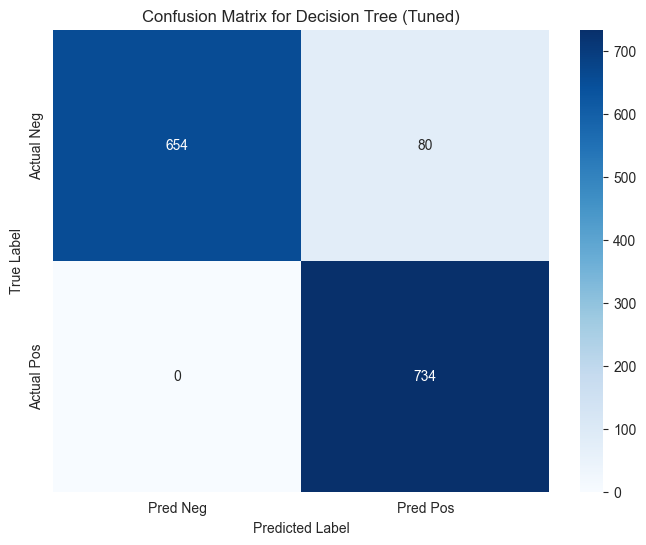

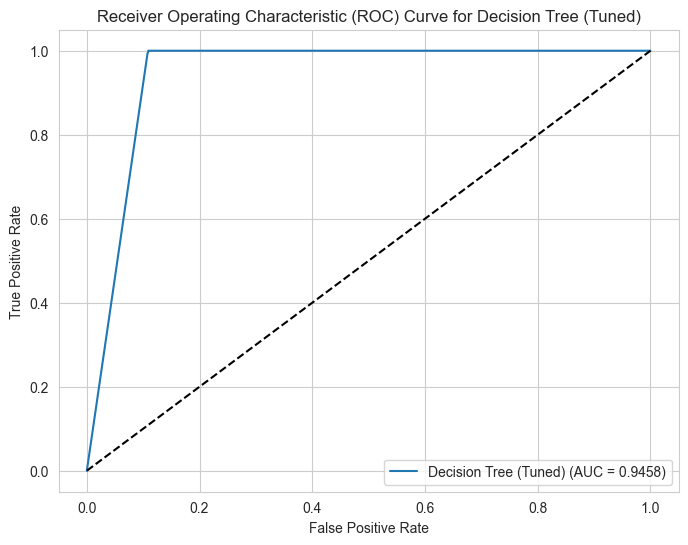

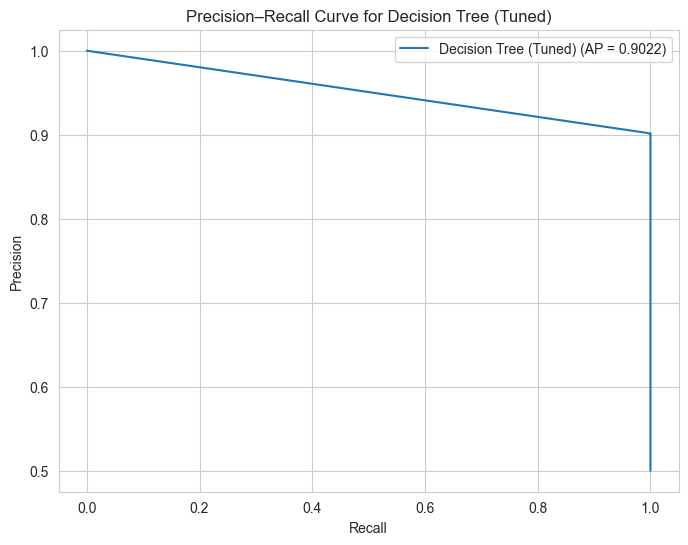

2025-01-01 20:53:20 | Analysis | INFO | Best Params for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
2025-01-01 20:53:20 | Analysis | INFO | Train Accuracy: 0.9997
2025-01-01 20:53:20 | Analysis | INFO | Test Accuracy: 0.9455
2025-01-01 20:53:20 | Analysis | INFO | Test ROC AUC: 0.9458
2025-01-01 20:53:20 | Analysis | INFO | GridSearch took 0.54s
2025-01-01 20:53:20 | Analysis | INFO | Cross-Val Accuracy (Training) for Decision Tree: 0.9311 ± 0.0088
2025-01-01 20:53:20 | Analysis | INFO | 
Analyzing Permutation Feature Importance for Decision Tree (Tuned)...
2025-01-01 20:53:20 | Analysis | INFO | Top 10 Most Important Features for Decision Tree (Tuned):
2025-01-01 20:53:20 | Analysis | INFO | 
| feature           |   importance_mean |   importance_std |
|:------------------|------------------:|-----------------:|
| euribor3m         |         0.245095  |       0.00711062 |
| nr.employed       |         0.230654  |       0.00688786 |
| age          

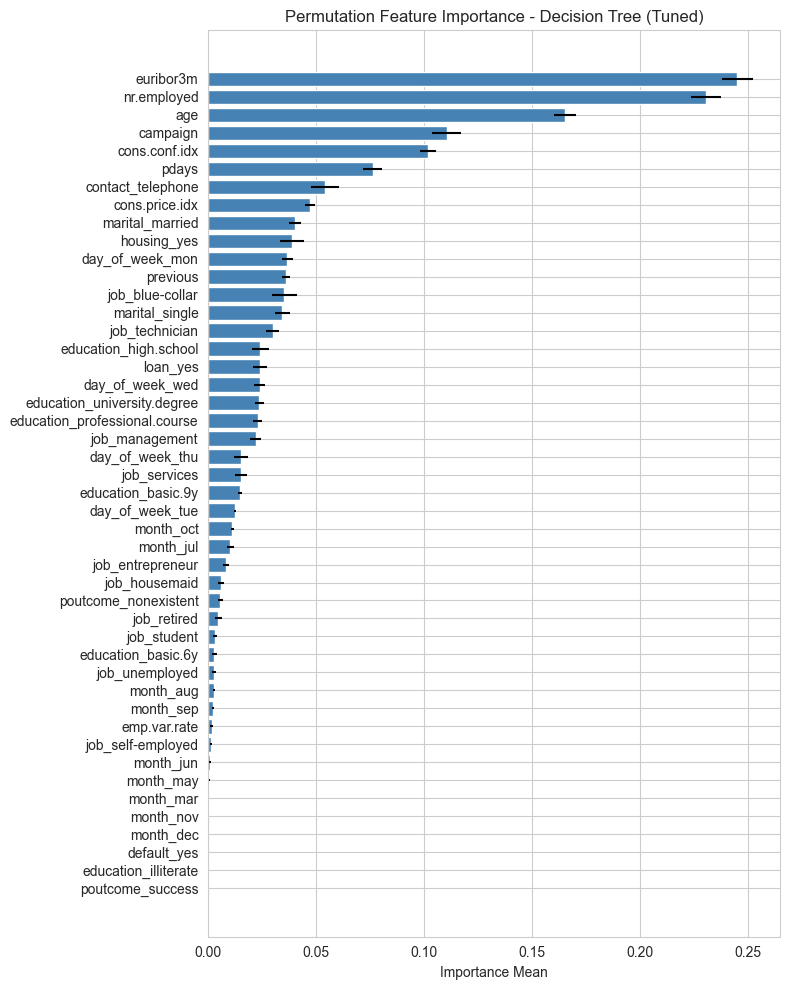

2025-01-01 20:53:20 | Analysis | INFO | 
Generating Partial Dependence Plots for Decision Tree (Tuned)...


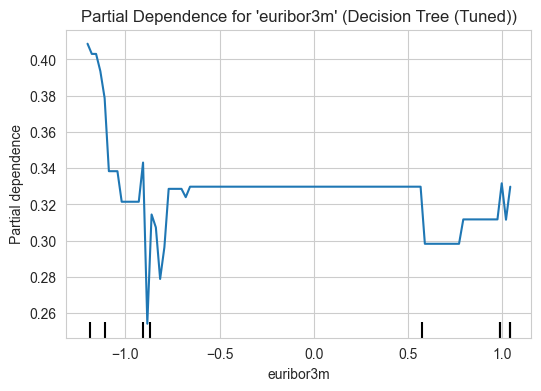

2025-01-01 20:53:20 | Analysis | INFO | PDP for feature 'euribor3m' saved as output/pdp_Decision_Tree_Tuned_euribor3m.png


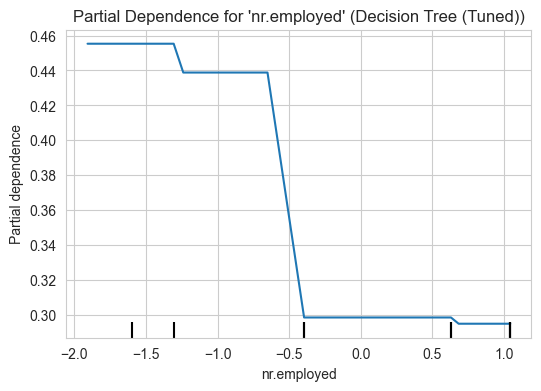

2025-01-01 20:53:20 | Analysis | INFO | PDP for feature 'nr.employed' saved as output/pdp_Decision_Tree_Tuned_nr.employed.png


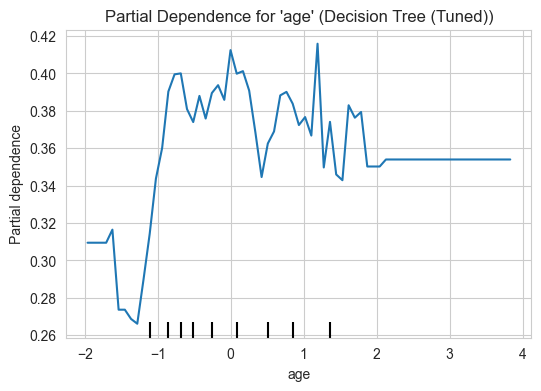

2025-01-01 20:53:20 | Analysis | INFO | PDP for feature 'age' saved as output/pdp_Decision_Tree_Tuned_age.png


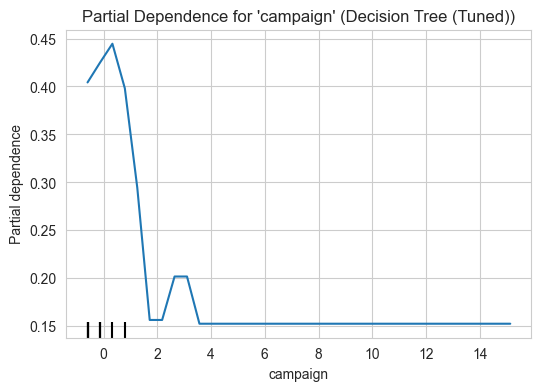

2025-01-01 20:53:20 | Analysis | INFO | PDP for feature 'campaign' saved as output/pdp_Decision_Tree_Tuned_campaign.png


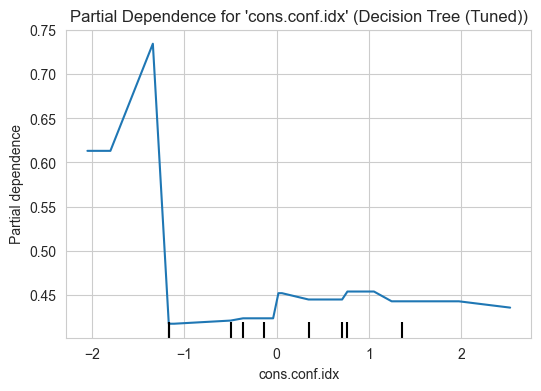

2025-01-01 20:53:21 | Analysis | INFO | PDP for feature 'cons.conf.idx' saved as output/pdp_Decision_Tree_Tuned_cons.conf.idx.png
2025-01-01 20:53:21 | Analysis | INFO | 
Starting hyperparameter tuning for KNN...


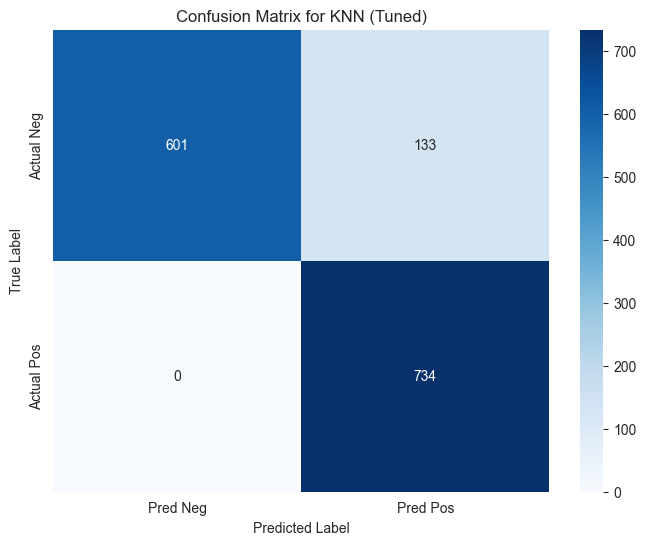

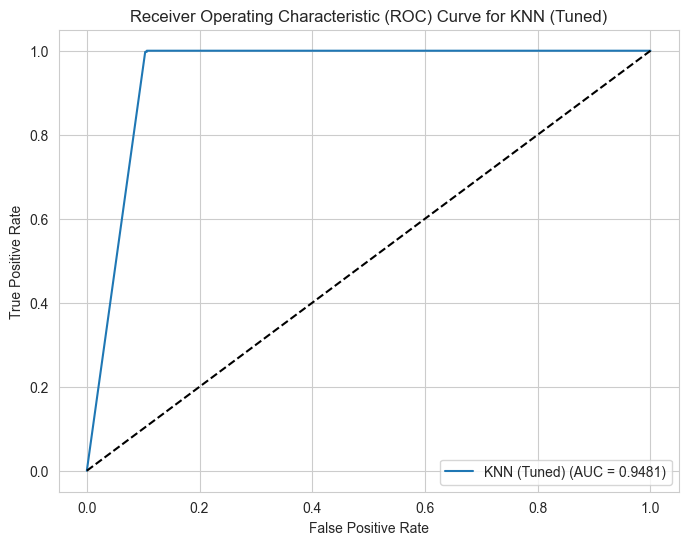

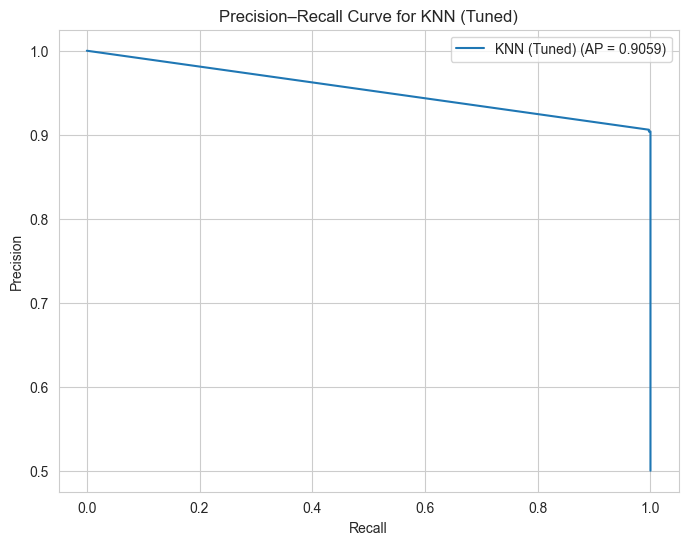

2025-01-01 20:53:21 | Analysis | INFO | Best Params for KNN: {'n_neighbors': 3, 'weights': 'distance'}
2025-01-01 20:53:21 | Analysis | INFO | Train Accuracy: 0.9997
2025-01-01 20:53:21 | Analysis | INFO | Test Accuracy: 0.9094
2025-01-01 20:53:21 | Analysis | INFO | Test ROC AUC: 0.9481
2025-01-01 20:53:21 | Analysis | INFO | GridSearch took 0.21s
2025-01-01 20:53:21 | Analysis | INFO | Cross-Val Accuracy (Training) for KNN: 0.8918 ± 0.0139
2025-01-01 20:53:21 | Analysis | INFO | 
Analyzing Permutation Feature Importance for KNN (Tuned)...
2025-01-01 20:53:23 | Analysis | INFO | Top 10 Most Important Features for KNN (Tuned):
2025-01-01 20:53:23 | Analysis | INFO | 
| feature         |   importance_mean |   importance_std |
|:----------------|------------------:|-----------------:|
| age             |        0.0741144  |       0.00573827 |
| pdays           |        0.0535422  |       0.00146735 |
| campaign        |        0.0410082  |       0.00391082 |
| cons.conf.idx   |        0.

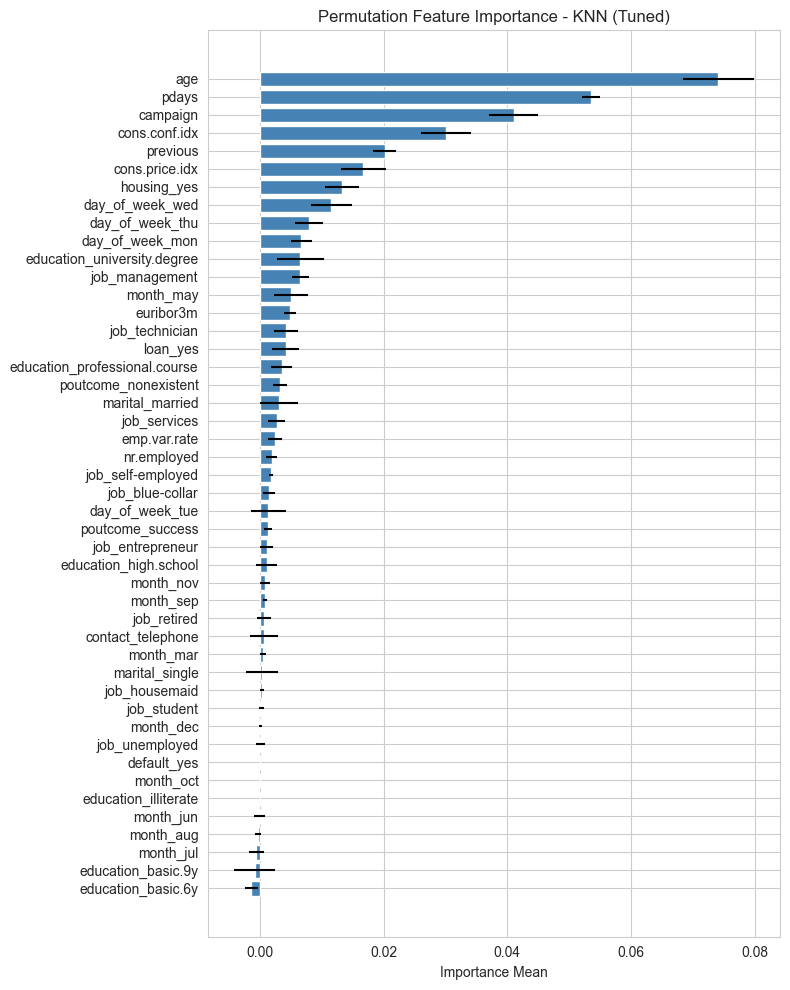

2025-01-01 20:53:23 | Analysis | INFO | 
Generating Partial Dependence Plots for KNN (Tuned)...


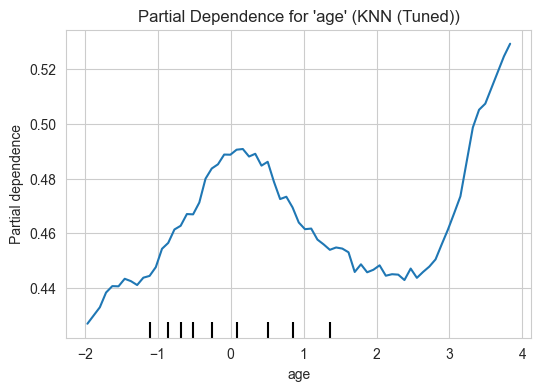

2025-01-01 20:53:24 | Analysis | INFO | PDP for feature 'age' saved as output/pdp_KNN_Tuned_age.png


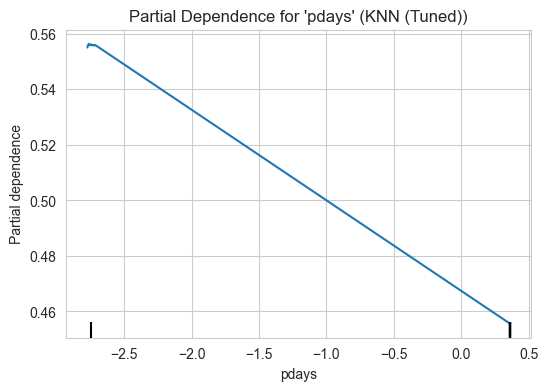

2025-01-01 20:53:25 | Analysis | INFO | PDP for feature 'pdays' saved as output/pdp_KNN_Tuned_pdays.png


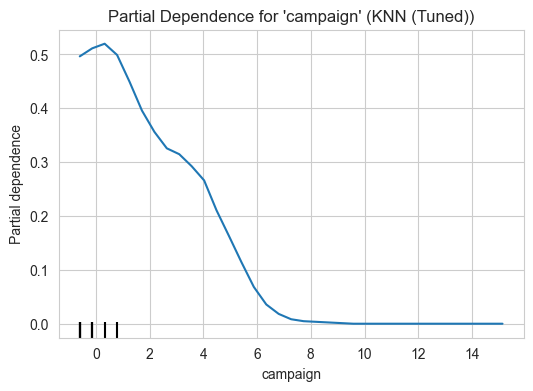

2025-01-01 20:53:25 | Analysis | INFO | PDP for feature 'campaign' saved as output/pdp_KNN_Tuned_campaign.png


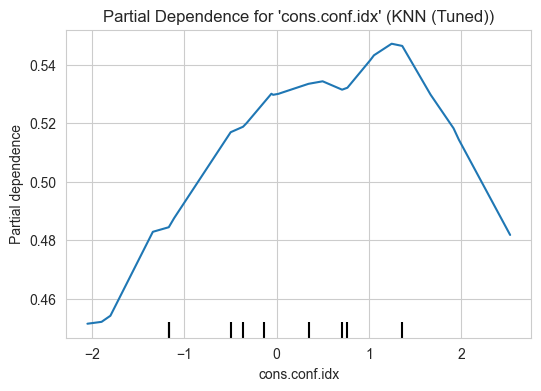

2025-01-01 20:53:26 | Analysis | INFO | PDP for feature 'cons.conf.idx' saved as output/pdp_KNN_Tuned_cons.conf.idx.png


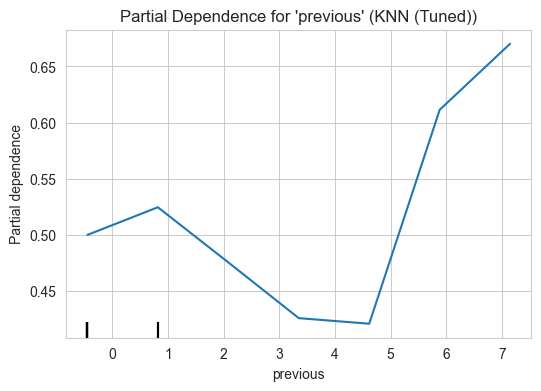

2025-01-01 20:53:26 | Analysis | INFO | PDP for feature 'previous' saved as output/pdp_KNN_Tuned_previous.png
2025-01-01 20:53:26 | Analysis | INFO | 
Starting hyperparameter tuning for SVM...


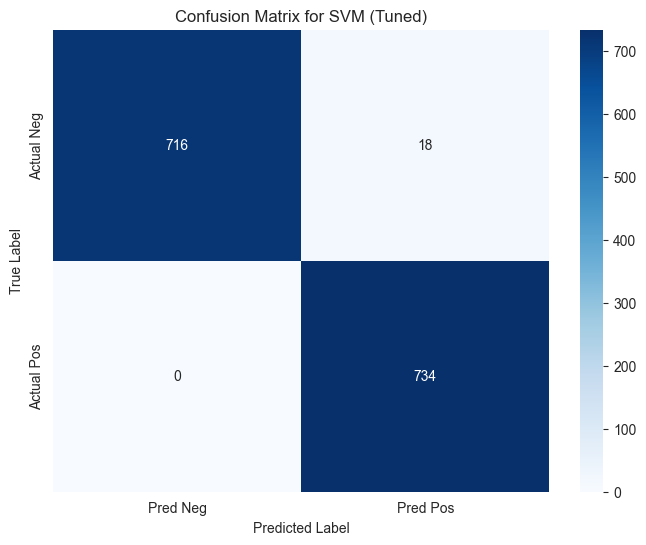

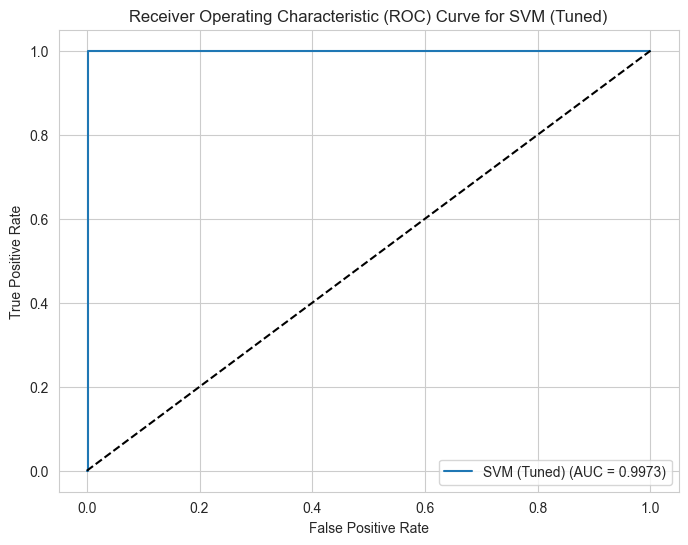

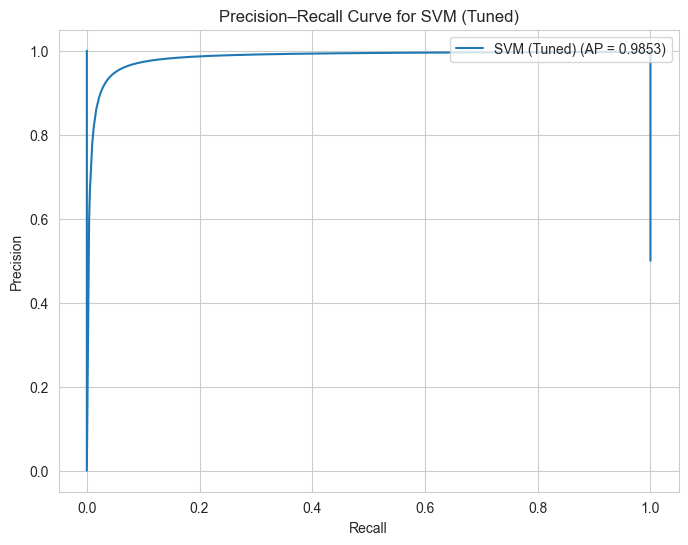

2025-01-01 20:54:29 | Analysis | INFO | Best Params for SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
2025-01-01 20:54:30 | Analysis | INFO | Train Accuracy: 0.9980
2025-01-01 20:54:30 | Analysis | INFO | Test Accuracy: 0.9877
2025-01-01 20:54:30 | Analysis | INFO | Test ROC AUC: 0.9973
2025-01-01 20:54:30 | Analysis | INFO | GridSearch took 62.20s
2025-01-01 20:54:38 | Analysis | INFO | Cross-Val Accuracy (Training) for SVM: 0.9852 ± 0.0027
2025-01-01 20:54:38 | Analysis | INFO | 
Analyzing Permutation Feature Importance for SVM (Tuned)...
2025-01-01 20:55:26 | Analysis | INFO | Top 10 Most Important Features for SVM (Tuned):
2025-01-01 20:55:26 | Analysis | INFO | 
| feature                     |   importance_mean |   importance_std |
|:----------------------------|------------------:|-----------------:|
| nr.employed                 |          0.289782 |       0.00622245 |
| age                         |          0.264986 |       0.0039486  |
| cons.conf.idx               |          0

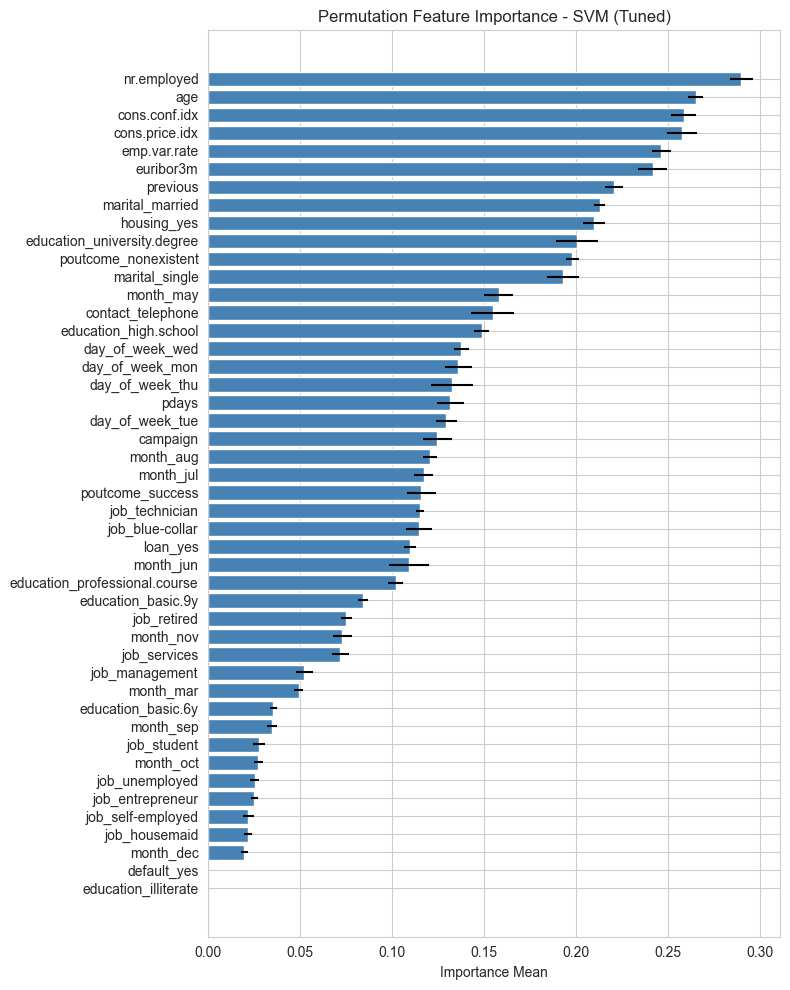

2025-01-01 20:55:27 | Analysis | INFO | 
Generating Partial Dependence Plots for SVM (Tuned)...


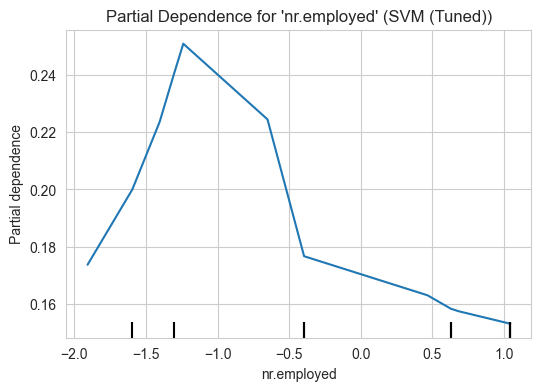

2025-01-01 20:55:36 | Analysis | INFO | PDP for feature 'nr.employed' saved as output/pdp_SVM_Tuned_nr.employed.png


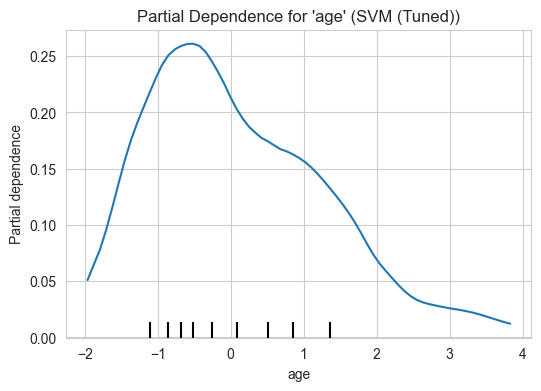

2025-01-01 20:56:31 | Analysis | INFO | PDP for feature 'age' saved as output/pdp_SVM_Tuned_age.png


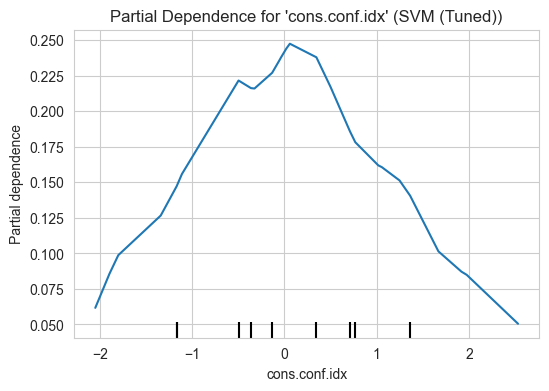

2025-01-01 20:56:53 | Analysis | INFO | PDP for feature 'cons.conf.idx' saved as output/pdp_SVM_Tuned_cons.conf.idx.png


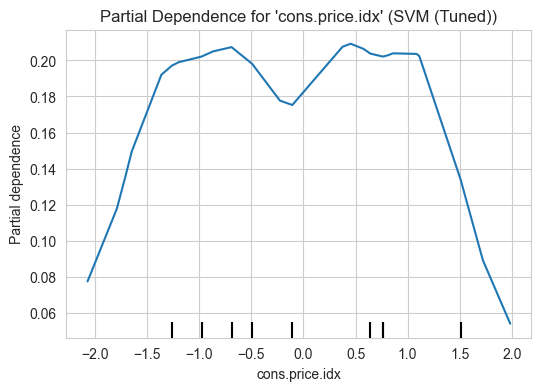

2025-01-01 20:57:15 | Analysis | INFO | PDP for feature 'cons.price.idx' saved as output/pdp_SVM_Tuned_cons.price.idx.png


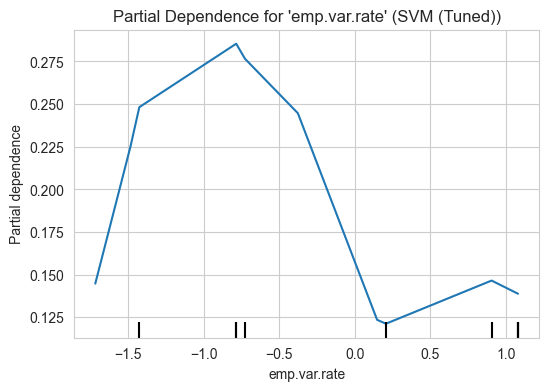

2025-01-01 20:57:24 | Analysis | INFO | PDP for feature 'emp.var.rate' saved as output/pdp_SVM_Tuned_emp.var.rate.png
2025-01-01 20:57:25 | Analysis | INFO | 
=== Tuned Model Comparison ===
2025-01-01 20:57:25 | Analysis | INFO | ### Comparison Table (Tuned)
| Model               |   Train Time (s) |   Train Accuracy |   Test Accuracy |   ROC AUC | Best Params                                                                             |
|:--------------------|-----------------:|-----------------:|----------------:|----------:|:----------------------------------------------------------------------------------------|
| Logistic Regression |             8.02 |           0.7391 |          0.7466 |    0.7966 | {'C': 10, 'l1_ratio': 0.9, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'} |
| Decision Tree       |             0.54 |           0.9997 |          0.9455 |    0.9458 | {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}                      |
| KNN        

In [ ]:
# Hyperparameter Tuning
param_grids = {
    'Logistic Regression': [
        {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear'],
            'max_iter': [1000, 2000]
        },
        {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['saga'],
            'l1_ratio': [0.5, 0.9],
            'max_iter': [1000, 2000]
        }
    ],
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': [1, 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }
}

tuned_models = []
for model_nm, grid in param_grids.items():
    tuned = train_and_tune_model(
        logger,
        model_nm,
        X_train,
        y_train,
        X_test,
        y_test,
        grid,
        scoring=make_scorer(roc_auc_score, greater_is_better=True),
        feature_names=feature_names
    )
    tuned_models.append([
        model_nm,
        f"{tuned['time']:.2f}",
        f"{tuned['train_acc']:.4f}",
        f"{tuned['test_acc']:.4f}",
        f"{tuned['roc_auc']:.4f}",
        tuned['best_params']
    ])

tuned_df = pd.DataFrame(tuned_models, columns=[
    'Model', 'Train Time (s)', 'Train Accuracy', 'Test Accuracy', 'ROC AUC', 'Best Params'
])

logger.info("\n=== Tuned Model Comparison ===")
logger.info("### Comparison Table (Tuned)\n" + tuned_df.to_markdown(index=False))

##### Questions
Please see Report